In [1]:
from matplotlib import pyplot as plt
import numpy as np
from numpy.polynomial.polynomial import Polynomial
from scipy.stats import pearsonr
from Datasets import exp_set_dict_warm_order, exp_set_dict_wind_order, wind_order_forcings, all_runs_wind_order, all_runs_warm_order
import Functions_data_analysis as fda
import Functions_load_output as flo
import Functions_plotting as fp
import pandas as pd

In [2]:
# Use importlib to reload modules after editing them
import importlib
importlib.reload(fp)

<module 'Functions_plotting' from '/glade/campaign/univ/ulnl0002/Gemma/Analysis/Functions_plotting.py'>

here
here


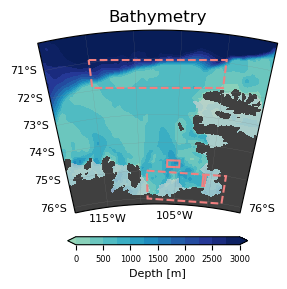

In [3]:
# Show locations of cross sections on bathymetry map
fp.plot_bathymetry_and_locs('AS_near', ['PIG', 'shelf_break','PITT','inner_shelf_corner'])
# plt.savefig('Plots/Figure_bathymetry_map_loc...'.png',dpi=600)

In [3]:
# Get PIG TC depths (only works if precalculated)

# set up data retrieval params
sets = ['ic_1995','ic_2001','ic_2008']
tcd_loc = 'PITT'
tc_temp = 0.5
forcings = wind_order_forcings #must match order of saved set numpy arrays (which is wind order)
#forcing_labs = [str(f)+'_x5' for f in forcings]

# get tcd_data
tcd_dict = {}
# contents of tcd_dict: run_name (e.g., 'run_forc_erai_2015_rep_ic_1995') --> [tcd_data,times]
for set_name in sets:
    print(set_name)
    set_tcd = np.load('Saved Arrays/tcd_'+str(tc_temp)+'deg_tseries_'+tcd_loc+'_'+set_name+'.npy')
    set_times = np.load('Saved Arrays/times_'+set_name+'.npy')
    for i in range(len(set_tcd)):
        if 'control' in set_name:
            run_name = 'Control'
        else:
            run_name = 'run_forc_erai_'+str(forcings[i])+'_rep_'+set_name
        tcd_dict[run_name] = set_tcd[i]

ic_1995
ic_2001
ic_2008


In [5]:
# calc undercurrent strength
# Get undercurrent strength for specified runs (either preload saved arrays or calc and save new arrays)

uc_region = 'shelf_break'

uc_dict = {}
for run in all_runs_wind_order:
    try:
        uc_tseries = np.load('Saved Arrays/Undercurrent_tseries/'+run+'.npy')
        uc_dict[run] = uc_tseries
        print('precalculated undercurrent strength found for', run)
    except:
        print('Calculating new undercurrent strength for',run,'...')
        uc_tseries = fda.calc_undercurrent_strength(run, uc_region)
        fname = 'Saved Arrays/Undercurrent_tseries/'+run+'.npy'
        np.save(fname, uc_tseries)
        print('Saved array as', fname)
        uc_dict[run] = uc_tseries

precalculated undercurrent strength found for run_forc_erai_2015_rep_ic_1995
precalculated undercurrent strength found for run_forc_erai_1991_rep_ic_1995
precalculated undercurrent strength found for run_forc_erai_1982_rep_ic_1995
precalculated undercurrent strength found for run_forc_erai_1994_rep_ic_1995
precalculated undercurrent strength found for run_forc_erai_1992_rep_ic_1995
precalculated undercurrent strength found for run_forc_erai_1984_rep_ic_1995
precalculated undercurrent strength found for run_forc_erai_2009_rep_ic_1995
precalculated undercurrent strength found for run_forc_erai_2003_rep_ic_1995
precalculated undercurrent strength found for run_forc_erai_1989_rep_ic_1995
precalculated undercurrent strength found for run_forc_erai_2011_rep_ic_1995
precalculated undercurrent strength found for run_forc_erai_2015_rep_ic_2001
precalculated undercurrent strength found for run_forc_erai_1991_rep_ic_2001
precalculated undercurrent strength found for run_forc_erai_1982_rep_ic_2001

In [6]:
# decompose undercurrent strength into barotropic and baroclinic

def decompose_uc(run, region):
    """
    For a given run, decompose the calculated undercurrent strength into barotropic and baroclinic components. 
    For each timestep, find the lat/lon with the max depth-avged U in the shelf break box. 
    That depth-avged U is the baroptropic component. 
    UC strength - barotropic is the baroclinic component. 
    """

    # get experiment U data in specified region
    lat1, lat2, lon1, lon2 = fda.analysis_region_dict[region]
    exp_U = flo.load_experiment_ds(run, 'all', 'state_3d_set2').UVELMASS
    exp_U_sb = exp_U.sel(lat=slice(lat1, lat2), lon_at_f_loc=slice(lon1, lon2))
    exp_U_depth_avg = exp_U_sb.mean(dim='depth')

    uc_tseries = np.zeros((60,))
    bt_tseries = np.zeros((60,))
    
    #get depth-avged U at the lat/lon with the max depth-avgd U
    for t in range(60):
        exp_U_depth_avg_t = exp_U_depth_avg.isel(time=t)
        # Find the indices of the maximum depth-avged value 
        max_idx = np.unravel_index(exp_U_depth_avg_t.argmax(), exp_U_depth_avg_t.shape)
        # Extract the lat, longitude corresponding to the maximum value
        max_lat = exp_U_depth_avg_t.lat[max_idx[0]].item()
        max_lon = exp_U_depth_avg_t.lon_at_f_loc[max_idx[1]].item()
        
        bt_tseries_t = exp_U_depth_avg_t.sel(lat = max_lat, lon_at_f_loc = max_lon)
        bt_tseries[t] = bt_tseries_t.values
    
    # subtract depth-avged U at that loc to get baroclinic component
    bc_tseries = uc_dict[run] - bt_tseries

    return bt_tseries, bc_tseries

uc_bt_dict = {}
uc_bc_dict = {}
for run in all_runs_wind_order:
    try:
        bt_run = np.load('Saved Arrays/Undercurrent_tseries/'+run+'_bt.npy')
        bc_run = np.load('Saved Arrays/Undercurrent_tseries/'+run+'_bc.npy')
        print('precalculated bt/bc components found for run',run)
    except:
        print('calculating and saving new bt/bc components for run',run)
        bt_run, bc_run = decompose_uc(run,uc_region)
        np.save('Saved Arrays/Undercurrent_tseries/'+run+'_bt.npy', bt_run)
        np.save('Saved Arrays/Undercurrent_tseries/'+run+'_bc.npy', bc_run)
    uc_bt_dict[run] = bt_run
    uc_bc_dict[run] = bc_run


precalculated bt/bc components found for run run_forc_erai_2015_rep_ic_1995
precalculated bt/bc components found for run run_forc_erai_1991_rep_ic_1995
precalculated bt/bc components found for run run_forc_erai_1982_rep_ic_1995
precalculated bt/bc components found for run run_forc_erai_1994_rep_ic_1995
precalculated bt/bc components found for run run_forc_erai_1992_rep_ic_1995
precalculated bt/bc components found for run run_forc_erai_1984_rep_ic_1995
precalculated bt/bc components found for run run_forc_erai_2009_rep_ic_1995
precalculated bt/bc components found for run run_forc_erai_2003_rep_ic_1995
precalculated bt/bc components found for run run_forc_erai_1989_rep_ic_1995
precalculated bt/bc components found for run run_forc_erai_2011_rep_ic_1995
precalculated bt/bc components found for run run_forc_erai_2015_rep_ic_2001
precalculated bt/bc components found for run run_forc_erai_1991_rep_ic_2001
precalculated bt/bc components found for run run_forc_erai_1982_rep_ic_2001
precalculate

In [164]:
# save undercurrent strength simple, based on lat/lon with max depth-avgd U from 200m+

def calc_uc2(run, region):
    """
    For a given run, calc uc strength and bt and bc components. 
    Find lat/lon with the max time-mean depth-avgd U. 
    For each timestep, 
    UC = max U in the water column. 
    BT = depth-avgd U at that loc. 
    BC = UC - BT

    
    """

    # get experiment U data in specified region
    lat1, lat2, lon1, lon2 = fda.analysis_region_dict[region]
    exp_U = flo.load_experiment_ds(run, 'all', 'state_3d_set2').UVELMASS
    exp_U = exp_U.isel(time=slice(0,60))
    exp_U_sb = exp_U.sel(lat=slice(lat1, lat2), lon_at_f_loc=slice(lon1, lon2),depth =slice(-200,-2000))
    exp_U_depth_avg = exp_U_sb.mean(dim='depth')
    exp_U_depth_time_avg = exp_U_depth_avg.mean(dim='time')

    # Find the indices of the maximum depth_avged and time-avged value 
    max_idx = np.unravel_index(exp_U_depth_time_avg.argmax(), exp_U_depth_time_avg.shape)
    # Extract the lat, longitude corresponding to the maximum value
    max_lat = exp_U_depth_time_avg.lat[max_idx[0]].item()
    max_lon = exp_U_depth_time_avg.lon_at_f_loc[max_idx[1]].item()
    print('UC lat/lon:', max_lat, max_lon) #generally around -71.25, -106.67
    uc_loc_U = exp_U_sb.sel(lat=max_lat, lon_at_f_loc = max_lon)
    uc_depth_avg_U = exp_U_depth_avg.sel(lat=max_lat, lon_at_f_loc = max_lon)

    # calc uc timeseries at max location
    uc_tseries = np.zeros((60,))
    
    #form tseries at the peak location with max U and depth-avgd U
    for t in range(60):
        uc_loc_U_t = uc_loc_U.isel(time=t)

        # uc strength = max U 
        uc_max_U_t = uc_loc_U_t.max()
        uc_tseries[t] = uc_max_U_t.values

    bt_tseries = np.array(uc_depth_avg_U)
    bc_tseries = uc_tseries - bt_tseries

    return uc_tseries, bt_tseries, bc_tseries

uc2_dict = {}
uc2_bt_dict = {}
uc2_bc_dict = {}
for run in all_runs_wind_order:
    print(run)
    try:
        uc_run = np.load('Saved Arrays/Undercurrent_tseries_2/'+run+'_uc.npy')
        bt_run = np.load('Saved Arrays/Undercurrent_tseries_2/'+run+'_bt.npy')
        bc_run = np.load('Saved Arrays/Undercurrent_tseries_2/'+run+'_bc.npy')
        print('precalculated bt/bc components found for run',run)
    except:
        print('calculating and saving new bt/bc components for run',run)
        uc_run, bt_run, bc_run = calc_uc2(run,uc_region)
        np.save('Saved Arrays/Undercurrent_tseries_2/'+run+'_uc.npy', uc_run)
        np.save('Saved Arrays/Undercurrent_tseries_2/'+run+'_bt.npy', bt_run)
        np.save('Saved Arrays/Undercurrent_tseries_2/'+run+'_bc.npy', bc_run)
    uc2_dict[run] = uc_run
    uc2_bt_dict[run] = bt_run
    uc2_bc_dict[run] = bc_run


run_forc_erai_2015_rep_ic_1995
precalculated bt/bc components found for run run_forc_erai_2015_rep_ic_1995
run_forc_erai_1991_rep_ic_1995
precalculated bt/bc components found for run run_forc_erai_1991_rep_ic_1995
run_forc_erai_1982_rep_ic_1995
precalculated bt/bc components found for run run_forc_erai_1982_rep_ic_1995
run_forc_erai_1994_rep_ic_1995
precalculated bt/bc components found for run run_forc_erai_1994_rep_ic_1995
run_forc_erai_1992_rep_ic_1995
precalculated bt/bc components found for run run_forc_erai_1992_rep_ic_1995
run_forc_erai_1984_rep_ic_1995
precalculated bt/bc components found for run run_forc_erai_1984_rep_ic_1995
run_forc_erai_2009_rep_ic_1995
precalculated bt/bc components found for run run_forc_erai_2009_rep_ic_1995
run_forc_erai_2003_rep_ic_1995
precalculated bt/bc components found for run run_forc_erai_2003_rep_ic_1995
run_forc_erai_1989_rep_ic_1995
precalculated bt/bc components found for run run_forc_erai_1989_rep_ic_1995
run_forc_erai_2011_rep_ic_1995
precal

In [8]:
# save undercurrent strength simple, based on lat/lon with max depth-avgd U from 0m+

def calc_uc3(run, region):
    """
    For a given run, calc uc strength and bt and bc components. 
    Find lat/lon with the max time-mean depth-avgd U. 
    For each timestep, 
    UC = max U in the water column. 
    BT = depth-avgd U at that loc. 
    BC = UC - BT

    
    """

    # get experiment U data in specified region
    lat1, lat2, lon1, lon2 = fda.analysis_region_dict[region]
    exp_U = flo.load_experiment_ds(run, 'all', 'state_3d_set2').UVELMASS
    exp_U = exp_U.isel(time=slice(0,60))
    exp_U_sb = exp_U.sel(lat=slice(lat1, lat2), lon_at_f_loc=slice(lon1, lon2),depth =slice(0,-2000))
    exp_U_depth_avg = exp_U_sb.mean(dim='depth')
    exp_U_depth_time_avg = exp_U_depth_avg.mean(dim='time')

    # Find the indices of the maximum depth_avged and time-avged value 
    max_idx = np.unravel_index(exp_U_depth_time_avg.argmax(), exp_U_depth_time_avg.shape)
    # Extract the lat, longitude corresponding to the maximum value
    max_lat = exp_U_depth_time_avg.lat[max_idx[0]].item()
    max_lon = exp_U_depth_time_avg.lon_at_f_loc[max_idx[1]].item()
    print('UC lat/lon:', max_lat, max_lon) #generally around -71.25, -106.67
    uc_loc_U = exp_U_sb.sel(lat=max_lat, lon_at_f_loc = max_lon)
    uc_depth_avg_U = exp_U_depth_avg.sel(lat=max_lat, lon_at_f_loc = max_lon)

    # calc uc timeseries at max location
    uc_tseries = np.zeros((60,))
    
    #form tseries at the peak location with max U and depth-avgd U
    for t in range(60):
        uc_loc_U_t = uc_loc_U.isel(time=t)

        # uc strength = max U 
        uc_max_U_t = uc_loc_U_t.max()
        uc_tseries[t] = uc_max_U_t.values

    bt_tseries = np.array(uc_depth_avg_U)
    bc_tseries = uc_tseries - bt_tseries

    return uc_tseries, bt_tseries, bc_tseries

uc3_dict = {}
uc3_bt_dict = {}
uc3_bc_dict = {}
for run in all_runs_wind_order:
    print(run)
    try:
        uc_run = np.load('Saved Arrays/Undercurrent_tseries_3/'+run+'_uc.npy')
        bt_run = np.load('Saved Arrays/Undercurrent_tseries_3/'+run+'_bt.npy')
        bc_run = np.load('Saved Arrays/Undercurrent_tseries_3/'+run+'_bc.npy')
        print('precalculated bt/bc components found for run',run)
    except:
        print('calculating and saving new bt/bc components for run',run)
        uc_run, bt_run, bc_run = calc_uc3(run,uc_region)
        np.save('Saved Arrays/Undercurrent_tseries_3/'+run+'_uc.npy', uc_run)
        np.save('Saved Arrays/Undercurrent_tseries_3/'+run+'_bt.npy', bt_run)
        np.save('Saved Arrays/Undercurrent_tseries_3/'+run+'_bc.npy', bc_run)
    uc3_dict[run] = uc_run
    uc3_bt_dict[run] = bt_run
    uc3_bc_dict[run] = bc_run


run_forc_erai_2015_rep_ic_1995
precalculated bt/bc components found for run run_forc_erai_2015_rep_ic_1995
run_forc_erai_1991_rep_ic_1995
precalculated bt/bc components found for run run_forc_erai_1991_rep_ic_1995
run_forc_erai_1982_rep_ic_1995
precalculated bt/bc components found for run run_forc_erai_1982_rep_ic_1995
run_forc_erai_1994_rep_ic_1995
precalculated bt/bc components found for run run_forc_erai_1994_rep_ic_1995
run_forc_erai_1992_rep_ic_1995
precalculated bt/bc components found for run run_forc_erai_1992_rep_ic_1995
run_forc_erai_1984_rep_ic_1995
precalculated bt/bc components found for run run_forc_erai_1984_rep_ic_1995
run_forc_erai_2009_rep_ic_1995
precalculated bt/bc components found for run run_forc_erai_2009_rep_ic_1995
run_forc_erai_2003_rep_ic_1995
precalculated bt/bc components found for run run_forc_erai_2003_rep_ic_1995
run_forc_erai_1989_rep_ic_1995
precalculated bt/bc components found for run run_forc_erai_1989_rep_ic_1995
run_forc_erai_2011_rep_ic_1995
precal

warm runs ['run_forc_erai_1982_rep_ic_2001', 'run_forc_erai_1984_rep_ic_2001', 'run_forc_erai_1989_rep_ic_2001', 'run_forc_erai_1992_rep_ic_2001']
cool runs ['run_forc_erai_1994_rep_ic_2001', 'run_forc_erai_2003_rep_ic_2001', 'run_forc_erai_2009_rep_ic_2001', 'run_forc_erai_1991_rep_ic_2001']
uc done
bt done
bc done


Text(0.5, 1.0, 'Warm Composite, ic_2001')

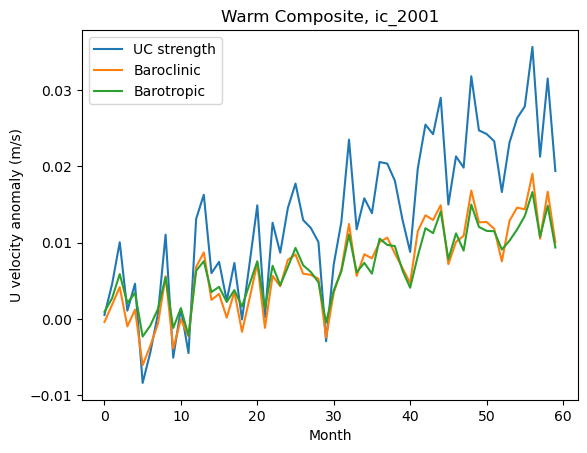

In [165]:
# calc composites and anomalies for uc and components using method 2 (from depth 200+)

exp_set = 'ic_2001'
exp_set_runs = exp_set_dict_wind_order[exp_set] #order doesn't matter, it uses the runs as dict keys
warm_order_runs = exp_set_dict_warm_order[exp_set]
warm_runs = warm_order_runs[0:4]
cool_runs = warm_order_runs[4:8]
print('warm runs',warm_runs)
print('cool runs',cool_runs)


# undercurrent
warm_comp_uc = np.mean(np.array([uc2_dict[run] for run in warm_runs]),axis=0) #shape 60
cool_comp_uc = np.mean(np.array([uc2_dict[run] for run in cool_runs]),axis=0)
ens_mean_uc = np.mean(np.array([uc2_dict[run] for run in exp_set_runs]),axis=0)
print('uc done')

#barotropic component
warm_comp_uc_bt = np.mean(np.array([uc2_bt_dict[run] for run in warm_runs]),axis=0) #shape 60
cool_comp_uc_bt = np.mean(np.array([uc2_bt_dict[run] for run in cool_runs]),axis=0)
ens_mean_uc_bt = np.mean(np.array([uc2_bt_dict[run] for run in exp_set_runs]),axis=0)
print('bt done')

# baroclinic component
warm_comp_uc_bc = np.mean(np.array([uc2_bc_dict[run] for run in warm_runs]),axis=0) #shape 60
cool_comp_uc_bc = np.mean(np.array([uc2_bc_dict[run] for run in cool_runs]),axis=0)
ens_mean_uc_bc = np.mean(np.array([uc2_bc_dict[run] for run in exp_set_runs]),axis=0)
print('bc done')

# plot warm composite anomaly undercurrent and its components using method 2

warm_comp_uc_anom = warm_comp_uc - ens_mean_uc
warm_comp_bt_anom = warm_comp_uc_bt - ens_mean_uc_bt
# warm_comp_bc_anom = warm_comp_uc_anom - warm_comp_bt_anom 
warm_comp_bc_anom = warm_comp_uc_bc - ens_mean_uc_bc #this is the same as the above line, which is good.

plt.figure()
plt.plot(warm_comp_uc_anom,label='UC strength')
plt.plot(warm_comp_bc_anom, label='Baroclinic')
plt.plot(warm_comp_bt_anom, label='Barotropic')
# plt.plot(ens_mean_uc_bt, label='Barotropic EM')
plt.ylabel('U velocity anomaly (m/s)')
plt.legend()
plt.xlabel('Month')
plt.title('Warm Composite, '+exp_set)

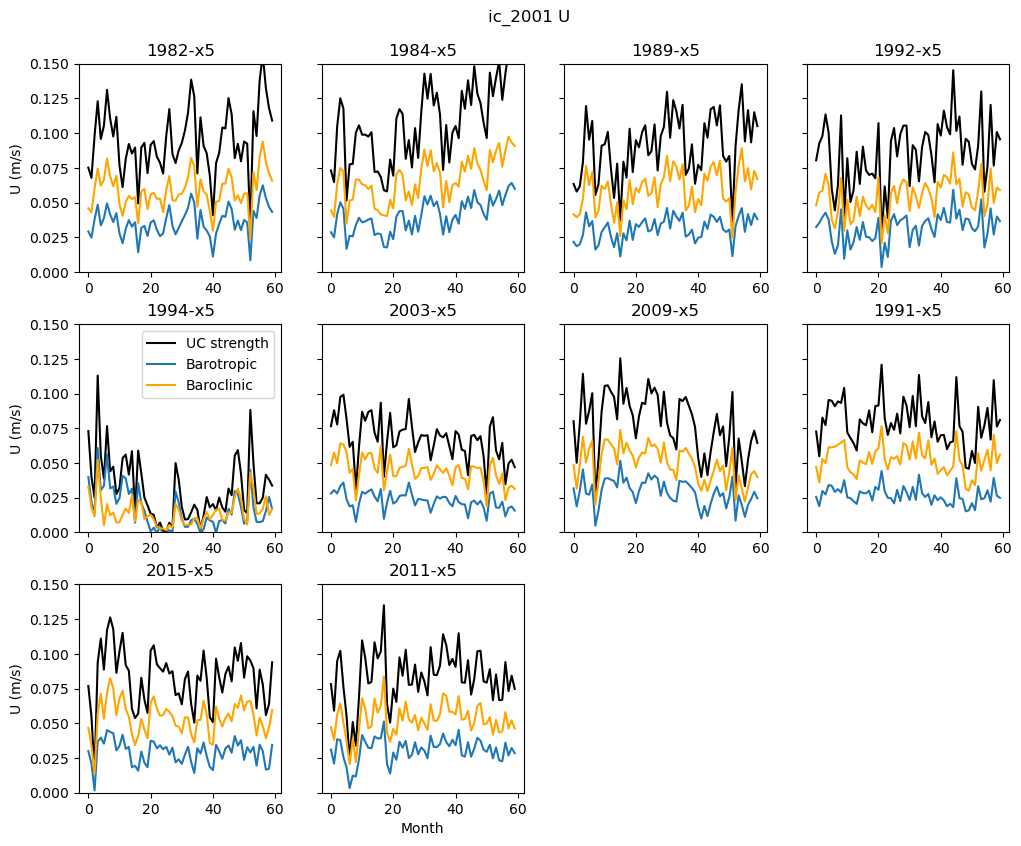

In [47]:
# plot all runs as actual values using menthod 2 (200m+)
fig, axes = plt.subplots(3,4,figsize=(12,9))
axes = axes.flatten()
for i in range(10): 
    ax = axes[i]
    run = all_runs_warm_order[i]
    ax.plot(uc2_dict[run],label='UC strength',color='k')
    ax.plot(uc2_bt_dict[run], label='Barotropic',color='tab:blue')
    ax.plot(uc2_bc_dict[run], label='Baroclinic',color='orange')
    ax.set_title(run.split('run_forc_erai_')[1][0:4]+'-x5')
    ax.set_ylim([0,0.15])
    if i%4 != 0:
        ax.set_yticklabels([])
    else:
        ax.set_ylabel('U (m/s)')
    if i == 4:
        ax.legend()
ax.set_xlabel('Month')

plt.subplots_adjust(hspace=0.25,top=0.92)
plt.suptitle(exp_set+' U')

# Remove the last two empty subplots
for ax in axes[-2:]:
    fig.delaxes(ax)

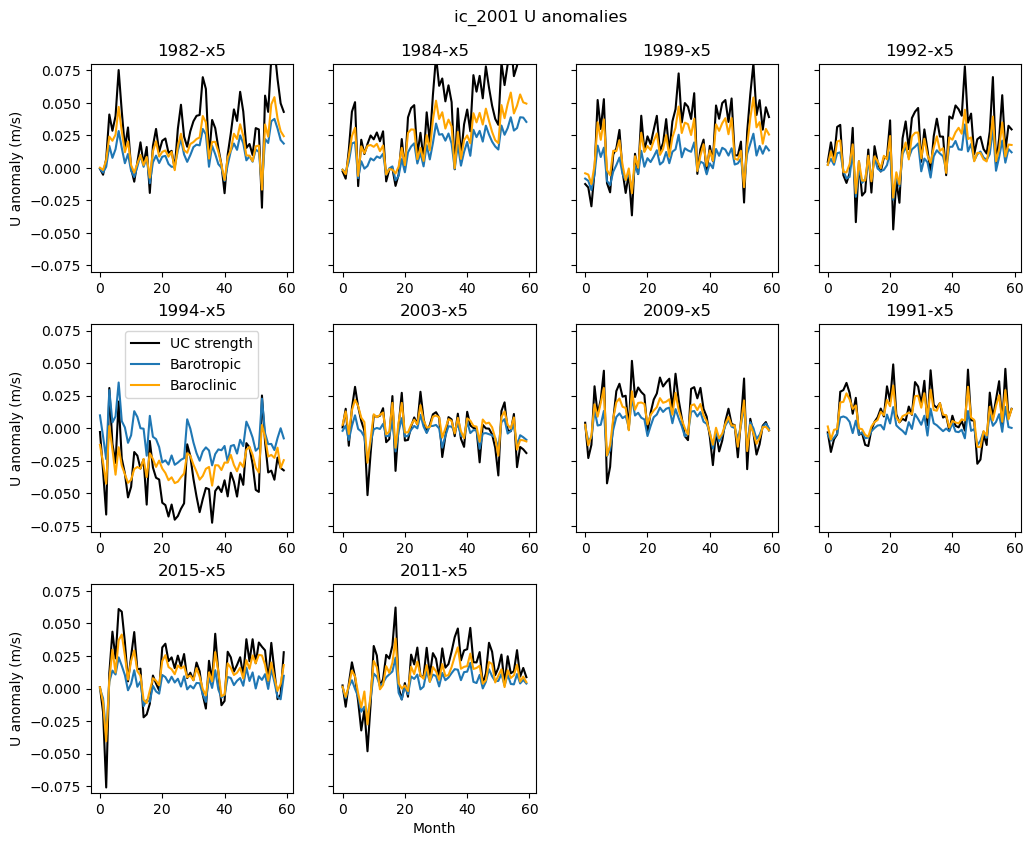

In [48]:
# plot all runs as anomalies using method 2 (200m+)
fig, axes = plt.subplots(3,4,figsize=(12,9))
axes = axes.flatten()
for i in range(10): 
    ax = axes[i]
    run = all_runs_warm_order[i]
    ax.plot(uc2_dict[run]-ens_mean_uc,label='UC strength',color='k')
    ax.plot(uc2_bt_dict[run]-ens_mean_uc_bt, label='Barotropic',color='tab:blue')
    ax.plot(uc2_bc_dict[run]-ens_mean_uc_bc, label='Baroclinic',color='orange')
    ax.set_title(run.split('run_forc_erai_')[1][0:4]+'-x5')
    ax.set_ylim([-0.08,0.08])
    if i%4 != 0:
        ax.set_yticklabels([])
    else:
        ax.set_ylabel('U anomaly (m/s)')
    if i == 4:
        ax.legend()
ax.set_xlabel('Month')

plt.subplots_adjust(hspace=0.25,top=0.92)
plt.suptitle(exp_set+ ' U anomalies')

# Remove the last two empty subplots
for ax in axes[-2:]:
    fig.delaxes(ax)

warm runs ['run_forc_erai_1982_rep_ic_2008', 'run_forc_erai_1984_rep_ic_2008', 'run_forc_erai_1989_rep_ic_2008', 'run_forc_erai_1992_rep_ic_2008']
cool runs ['run_forc_erai_1994_rep_ic_2008', 'run_forc_erai_2003_rep_ic_2008', 'run_forc_erai_2009_rep_ic_2008', 'run_forc_erai_1991_rep_ic_2008']

year 1 ens mean uc strength: 0.08287245
total UC strength anomalies by year:
Year 1 anomaly: -0.004 m/s, a -4.67% change from EM yr 1
Year 2 anomaly: 0.008 m/s, a 9.76% change from EM yr 1
Year 3 anomaly: 0.012 m/s, a 14.35% change from EM yr 1
Year 4 anomaly: 0.022 m/s, a 27.00% change from EM yr 1
Year 5 anomaly: 0.021 m/s, a 25.12% change from EM yr 1

year 1 ens mean uc bt strength: 0.03431208
Barotropic strength anomalies by year:
Year 1 anomaly: -0.001 m/s, a -2.38% change from EM yr 1
Year 2 anomaly: 0.005 m/s, a 14.42% change from EM yr 1
Year 3 anomaly: 0.005 m/s, a 15.46% change from EM yr 1
Year 4 anomaly: 0.009 m/s, a 25.26% change from EM yr 1
Year 5 anomaly: 0.008 m/s, a 22.73% chan

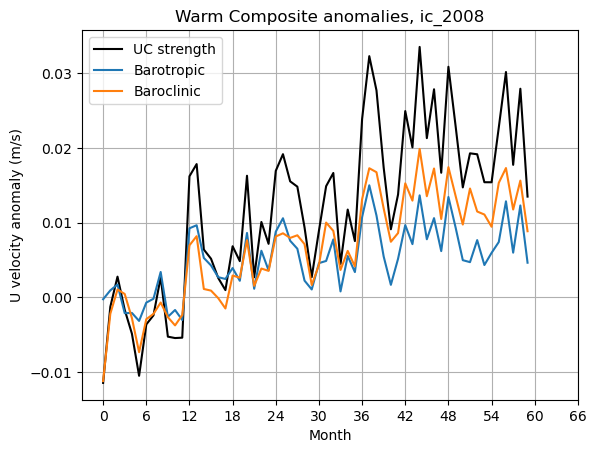

In [230]:
# calc composites and anomalies for uc and components using method 3 (0m+)

exp_set = 'ic_2008'
exp_set_runs = exp_set_dict_wind_order[exp_set] #order doesn't matter, it uses the runs as dict keys
warm_order_runs = exp_set_dict_warm_order[exp_set]
warm_runs = warm_order_runs[0:4]
cool_runs = warm_order_runs[4:8]
print('warm runs',warm_runs)
print('cool runs',cool_runs)


# undercurrent
warm_comp_uc = np.mean(np.array([uc3_dict[run] for run in warm_runs]),axis=0) #shape 60
cool_comp_uc = np.mean(np.array([uc3_dict[run] for run in cool_runs]),axis=0)
ens_mean_uc = np.mean(np.array([uc3_dict[run] for run in exp_set_runs]),axis=0)

#barotropic component
warm_comp_uc_bt = np.mean(np.array([uc3_bt_dict[run] for run in warm_runs]),axis=0) #shape 60
cool_comp_uc_bt = np.mean(np.array([uc3_bt_dict[run] for run in cool_runs]),axis=0)
ens_mean_uc_bt = np.mean(np.array([uc3_bt_dict[run] for run in exp_set_runs]),axis=0)

# baroclinic component
warm_comp_uc_bc = np.mean(np.array([uc3_bc_dict[run] for run in warm_runs]),axis=0) #shape 60
cool_comp_uc_bc = np.mean(np.array([uc3_bc_dict[run] for run in cool_runs]),axis=0)
ens_mean_uc_bc = np.mean(np.array([uc3_bc_dict[run] for run in exp_set_runs]),axis=0)

# plot warm composite anomaly undercurrent and its components using method 2

warm_comp_uc_anom = warm_comp_uc - ens_mean_uc
warm_comp_bt_anom = warm_comp_uc_bt - ens_mean_uc_bt
warm_comp_bc_anom = warm_comp_uc_anom - warm_comp_bt_anom #is this the same as the next line?
# warm_comp_bc_anom = warm_comp_uc_bc - ens_mean_uc_bc

plt.figure()
plt.plot(warm_comp_uc_anom,label='UC strength',color='k')
plt.plot(warm_comp_bt_anom, label='Barotropic',color='tab:blue')
plt.plot(warm_comp_bc_anom, label='Baroclinic',color='tab:orange')

# plt.plot(ens_mean_uc_bt, label='Barotropic EM')
plt.ylabel('U velocity anomaly (m/s)')
plt.legend()
plt.xlabel('Month')
plt.grid()
plt.xticks(np.arange(0,72,6))
plt.title('Warm Composite anomalies, '+exp_set)

# plot warm composite change in each year
yr_1_uc = np.mean(ens_mean_uc[0:12])
print('\nyear 1 ens mean uc strength: {:.8f}'.format(yr_1_uc))
print('total UC strength anomalies by year:')
for i in range(5):
    yr_i_uc_anom = np.mean(warm_comp_uc_anom[i*12:i*12+12])
    print('Year '+str(i+1)+' anomaly: {:.3f} m/s'.format(yr_i_uc_anom)+', a {:.2f}% change from EM yr 1'.format((yr_i_uc_anom/yr_1_uc)*100))

yr_1_uc_bt = np.mean(ens_mean_uc_bt[0:12])
print('\nyear 1 ens mean uc bt strength: {:.8f}'.format(yr_1_uc_bt))
print('Barotropic strength anomalies by year:')
for i in range(5):
    yr_i_uc_bt_anom = np.mean(warm_comp_bt_anom[i*12:i*12+12])
    print('Year '+str(i+1)+' anomaly: {:.3f} m/s'.format(yr_i_uc_bt_anom)+', a {:.2f}% change from EM yr 1'.format((yr_i_uc_bt_anom/yr_1_uc_bt)*100))

yr_1_uc_bc = np.mean(ens_mean_uc_bc[0:12])
print('\nyear 1 ens mean uc bc strength: {:.8f}'.format(yr_1_uc_bc))
print('Baroclinic strength anomalies by year:')
for i in range(5):
    yr_i_uc_bc_anom = np.mean(warm_comp_bc_anom[i*12:i*12+12])
    print('Year '+str(i+1)+' anomaly: {:.3f} m/s'.format(yr_i_uc_bc_anom)+', a {:.2f}% change from EM yr 1'.format((yr_i_uc_bc_anom/yr_1_uc_bc)*100))


In [ ]:
# Plot ensemble means
plt.figure()
plt.plot(ens_mean_uc,label='UC strength')
plt.plot(ens_mean_uc_bc, label='Baroclinic')
plt.plot(ens_mean_uc_bt, label='Barotropic')
# plt.plot(ens_mean_uc_bt, label='Barotropic EM')
plt.ylabel('U velocity anomaly (m/s)')
plt.legend()
plt.xlabel('Month')
plt.xticks(np.arange(0,72,12))
plt.title('Warm Composite, '+exp_set)

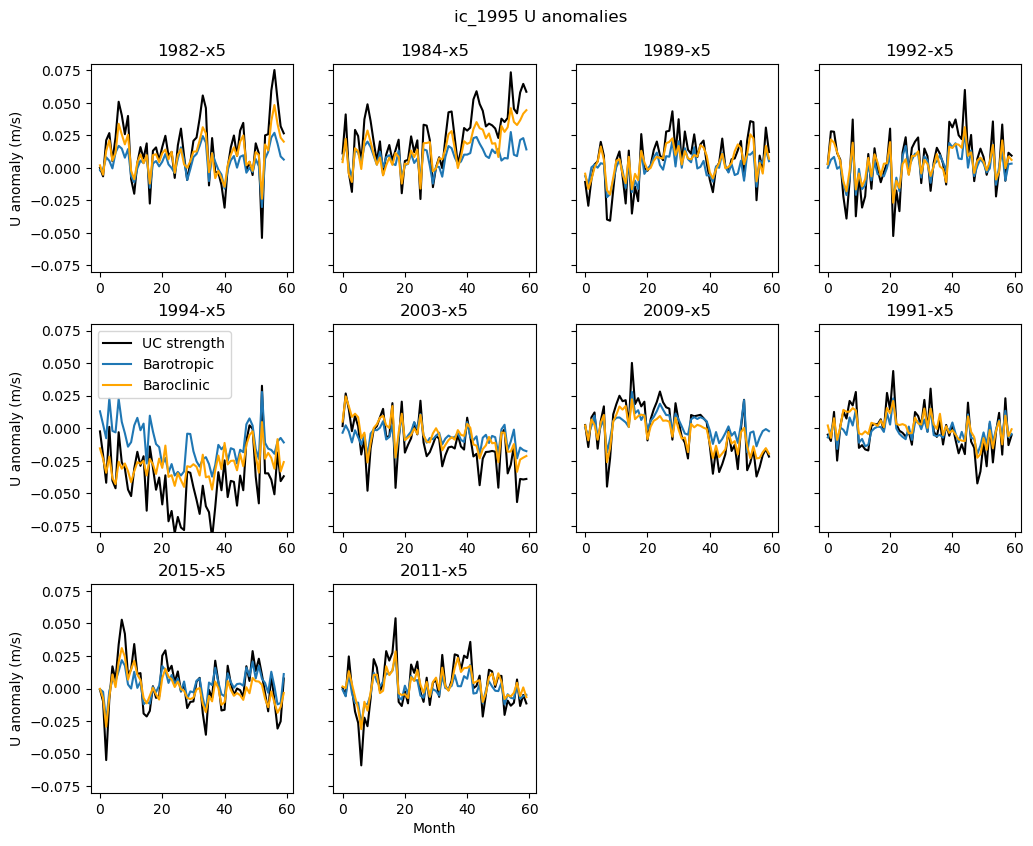

In [59]:
# plot all runs as anomalies using method 3 (0m+)
fig, axes = plt.subplots(3,4,figsize=(12,9))
axes = axes.flatten()
for i in range(10): 
    ax = axes[i]
    run = all_runs_warm_order[i]
    ax.plot(uc3_dict[run]-ens_mean_uc,label='UC strength',color='k')
    ax.plot(uc3_bt_dict[run]-ens_mean_uc_bt, label='Barotropic',color='tab:blue')
    ax.plot(uc3_bc_dict[run]-ens_mean_uc_bc, label='Baroclinic',color='orange')
    ax.set_title(run.split('run_forc_erai_')[1][0:4]+'-x5')
    ax.set_ylim([-0.08,0.08])
    if i%4 != 0:
        ax.set_yticklabels([])
    else:
        ax.set_ylabel('U anomaly (m/s)')
    if i == 4:
        ax.legend()
ax.set_xlabel('Month')

plt.subplots_adjust(hspace=0.25,top=0.92)
plt.suptitle(exp_set+ ' U anomalies')

# Remove the last two empty subplots
for ax in axes[-2:]:
    fig.delaxes(ax)

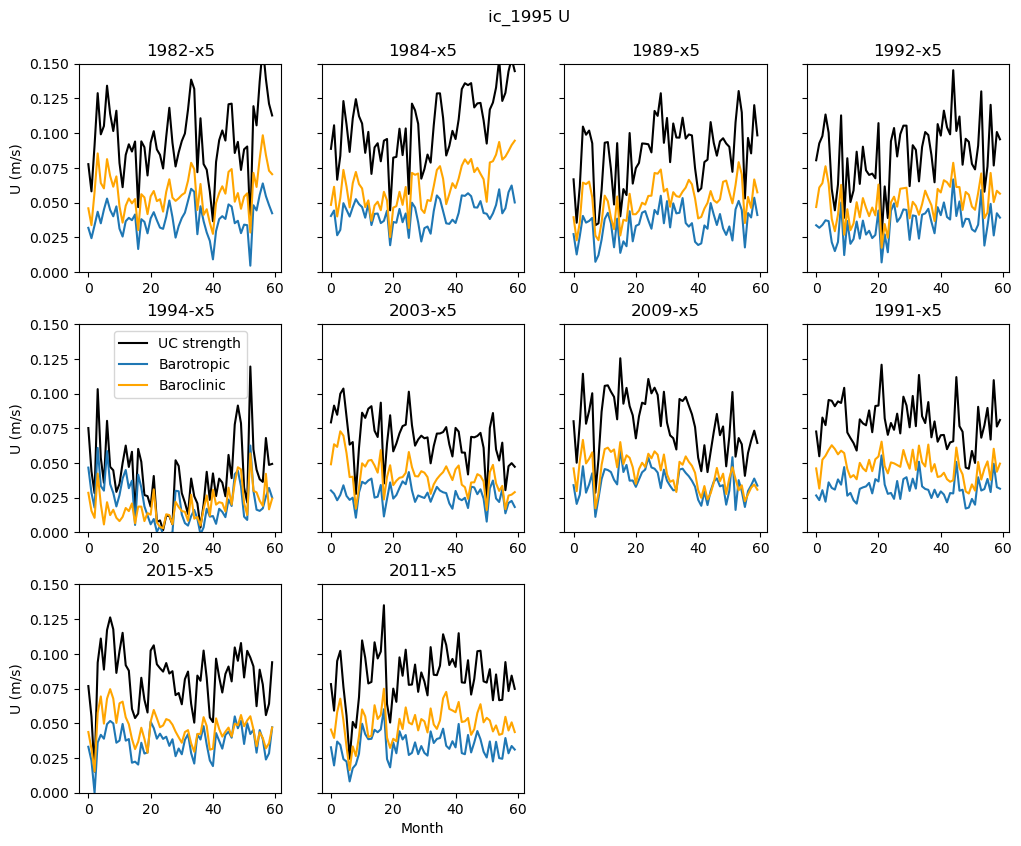

In [62]:
# plot all runs as actual values using method 3 (0m+)
fig, axes = plt.subplots(3,4,figsize=(12,9))
axes = axes.flatten()
for i in range(10): 
    ax = axes[i]
    run = all_runs_warm_order[i]
    ax.plot(uc3_dict[run],label='UC strength',color='k')
    ax.plot(uc3_bt_dict[run], label='Barotropic',color='tab:blue')
    ax.plot(uc3_bc_dict[run], label='Baroclinic',color='orange')
    ax.set_title(run.split('run_forc_erai_')[1][0:4]+'-x5')
    ax.set_ylim([0,0.15])
    if i%4 != 0:
        ax.set_yticklabels([])
    else:
        ax.set_ylabel('U (m/s)')
    if i == 4:
        ax.legend()
ax.set_xlabel('Month')

plt.subplots_adjust(hspace=0.25,top=0.92)
plt.suptitle(exp_set+ ' U')

# Remove the last two empty subplots
for ax in axes[-2:]:
    fig.delaxes(ax)

In [11]:
# Calc temps at a given loc at a given depth

def calc_temp(run, region, depth):
    exp_temp_full = flo.load_experiment_ds(run, 'all', 'state_3d_set2').THETA
    exp_temp_full = exp_temp_full.isel(time=slice(0,60))
    try:
        lati1, lati2, loni1, loni2 = fda.trough_idx_dict[region]
        exp_temp_reg = exp_temp_full.isel(lat=slice(lati1, lati2), lon=slice(loni1, loni2))
    except:
        lat1, lat2, lon1, lon2 = fda.analysis_region_dict[region]
        exp_temp_reg = exp_temp_full.sel(lat=slice(lat1, lat2), lon=slice(lon1, lon2))
    exp_temp_z = exp_temp_reg.sel(depth=depth,method='nearest')
    exp_temp = exp_temp_z.mean(dim='lat')
    exp_temp = exp_temp.mean(dim='lon')

    return exp_temp.values


# temp_loc = 'PIG'
temp_loc = 'inner_shelf_corner'
temp_depth = -300
temp_dict = {}
for run in all_runs_wind_order:
    print(run)
    try:
        temp_run = np.load('Saved Arrays/Temp_tseries/'+str(temp_depth)[1:]+'m_'+run+'_'+temp_loc+'.npy')
        print('precalculated temps found for', run)
    except:
        temp_run = calc_temp(run, temp_loc, temp_depth)
        fname = 'Saved Arrays/Temp_tseries/'+str(temp_depth)[1:]+'m_'+run+'_'+temp_loc+'.npy'
        np.save(fname, temp_run)
        print('Saved array as', fname)
    
    temp_dict[run] = temp_run

run_forc_erai_2015_rep_ic_1995
Saved array as Saved Arrays/Temp_tseries/300m_run_forc_erai_2015_rep_ic_1995_inner_shelf_corner.npy
run_forc_erai_1991_rep_ic_1995
Saved array as Saved Arrays/Temp_tseries/300m_run_forc_erai_1991_rep_ic_1995_inner_shelf_corner.npy
run_forc_erai_1982_rep_ic_1995
Saved array as Saved Arrays/Temp_tseries/300m_run_forc_erai_1982_rep_ic_1995_inner_shelf_corner.npy
run_forc_erai_1994_rep_ic_1995
Saved array as Saved Arrays/Temp_tseries/300m_run_forc_erai_1994_rep_ic_1995_inner_shelf_corner.npy
run_forc_erai_1992_rep_ic_1995
Saved array as Saved Arrays/Temp_tseries/300m_run_forc_erai_1992_rep_ic_1995_inner_shelf_corner.npy
run_forc_erai_1984_rep_ic_1995
Saved array as Saved Arrays/Temp_tseries/300m_run_forc_erai_1984_rep_ic_1995_inner_shelf_corner.npy
run_forc_erai_2009_rep_ic_1995
Saved array as Saved Arrays/Temp_tseries/300m_run_forc_erai_2009_rep_ic_1995_inner_shelf_corner.npy
run_forc_erai_2003_rep_ic_1995
Saved array as Saved Arrays/Temp_tseries/300m_run_fo

warm runs ['run_forc_erai_1982_rep_ic_2008', 'run_forc_erai_1984_rep_ic_2008', 'run_forc_erai_1989_rep_ic_2008', 'run_forc_erai_1992_rep_ic_2008']
cool runs ['run_forc_erai_1994_rep_ic_2008', 'run_forc_erai_2003_rep_ic_2008', 'run_forc_erai_2009_rep_ic_2008', 'run_forc_erai_1991_rep_ic_2008']
year 1 EM temp: -0.19
Year 1 annual mean temp: 0.03, a -16.73% change from EM yr 1
Year 2 annual mean temp: 0.12, a -61.32% change from EM yr 1
Year 3 annual mean temp: 0.19, a -102.40% change from EM yr 1
Year 4 annual mean temp: 0.26, a -138.65% change from EM yr 1
Year 5 annual mean temp: 0.31, a -163.91% change from EM yr 1


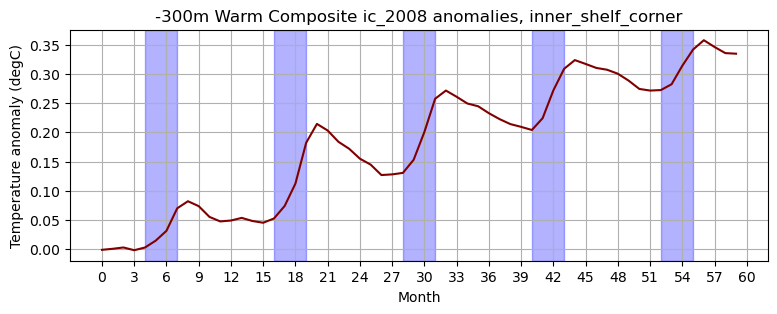

In [29]:
# Calc warm composite and cool composites plot temp

exp_set = 'ic_2008'
exp_set_runs = exp_set_dict_wind_order[exp_set] #order doesn't matter, it uses the runs as dict keys
warm_order_runs = exp_set_dict_warm_order[exp_set]
warm_runs = warm_order_runs[0:4]
cool_runs = warm_order_runs[4:8]
print('warm runs',warm_runs)
print('cool runs',cool_runs)

warm_comp_temp = np.mean(np.array([temp_dict[run] for run in warm_runs]),axis=0)
cool_comp_temp = np.mean(np.array([temp_dict[run] for run in cool_runs]),axis=0)
ens_mean_temp = np.mean(np.array([temp_dict[run] for run in exp_set_runs]),axis=0)

#PLOT temp anomalies -----------------------
fig,ax0 = plt.subplots(1,1,figsize=(9,3))
window = 1

warm_comp_temp_anom = pd.Series(warm_comp_temp - ens_mean_temp).rolling(window=window).mean()
ax0.plot(warm_comp_temp_anom,color='maroon')

ax0.set_title(str(temp_depth)+'m Warm Composite '+exp_set+' anomalies, '+temp_loc)
ax0.set_xlabel('Month')
ax0.set_xticks(np.arange(0,72,3))
ax0.set_ylabel('Temperature anomaly (degC)')
ax0.grid()

# Add shaded vertical boxes to highlight winter
season_start_idx = 4 #2 is feb, so JJA = 4,5,6
for start in range(season_start_idx, 60, 12):
    end = start + 3
    if end <= 60:
        ax0.axvspan(start, start+3, color='blue', alpha=0.3)

yr1_em_temp = np.mean(ens_mean_temp[0:12])
print('year 1 EM temp: {:.2f}'.format(yr1_em_temp))
for i in range(5):
    yr_i_temp_anom = np.mean(warm_comp_temp_anom[i*12:i*12+12])
    print('Year '+str(i+1)+' annual mean temp: {:.2f}'.format(yr_i_temp_anom)\
         +', a {:.2f}% change from EM yr 1'.format((yr_i_temp_anom/yr1_em_temp)*100))



In [267]:
# Calc salinity in location at a given depth

def calc_salinity(run, region, depth):
    exp_sal_full = flo.load_experiment_ds(run, 'all', 'state_3d_set2').SALT
    exp_sal_full = exp_sal_full.isel(time=slice(0,60))
    try:
        lati1, lati2, loni1, loni2 = fda.trough_idx_dict[region]
        exp_sal_reg = exp_sal_full.isel(lat=slice(lati1, lati2), lon=slice(loni1, loni2))
    except:
        lat1, lat2, lon1, lon2 = fda.analysis_region_dict[region]
        exp_sal_reg = exp_sal_full.sel(lat=slice(lat1, lat2), lon=slice(lon1, lon2))
    exp_sal_z = exp_sal_reg.sel(depth=depth,method='nearest')
    exp_sal = exp_sal_z.mean(dim='lat')
    exp_sal = exp_sal.mean(dim='lon')

    return exp_sal.values


sal_loc = 'PIG'
# sal_loc = 'inner_shelf_corner'
sal_depth = 0 #0 PIG and inner_Shelf_corner and -100 inner_shelf_corner are saved 
sal_dict = {}
for run in all_runs_wind_order:
    print(run)
    try:
        sal_run = np.load('Saved Arrays/sal_tseries/'+str(sal_depth)+'m_'+run+'_'+sal_loc+'.npy')
        print('precalculated sals found for', run)
    except:
        sal_run = calc_salinity(run, sal_loc, sal_depth)
        fname = 'Saved Arrays/sal_tseries/'+str(sal_depth)+'m_'+run+'_'+sal_loc+'.npy'
        np.save(fname, sal_run)
        print('Saved array as', fname)
    
    sal_dict[run] = sal_run

run_forc_erai_2015_rep_ic_1995
precalculated sals found for run_forc_erai_2015_rep_ic_1995
run_forc_erai_1991_rep_ic_1995
precalculated sals found for run_forc_erai_1991_rep_ic_1995
run_forc_erai_1982_rep_ic_1995
precalculated sals found for run_forc_erai_1982_rep_ic_1995
run_forc_erai_1994_rep_ic_1995
precalculated sals found for run_forc_erai_1994_rep_ic_1995
run_forc_erai_1992_rep_ic_1995
precalculated sals found for run_forc_erai_1992_rep_ic_1995
run_forc_erai_1984_rep_ic_1995
precalculated sals found for run_forc_erai_1984_rep_ic_1995
run_forc_erai_2009_rep_ic_1995
precalculated sals found for run_forc_erai_2009_rep_ic_1995
run_forc_erai_2003_rep_ic_1995
precalculated sals found for run_forc_erai_2003_rep_ic_1995
run_forc_erai_1989_rep_ic_1995
precalculated sals found for run_forc_erai_1989_rep_ic_1995
run_forc_erai_2011_rep_ic_1995
precalculated sals found for run_forc_erai_2011_rep_ic_1995
run_forc_erai_2015_rep_ic_2001
precalculated sals found for run_forc_erai_2015_rep_ic_2001

warm runs ['run_forc_erai_1982_rep_ic_1995', 'run_forc_erai_1984_rep_ic_1995', 'run_forc_erai_1989_rep_ic_1995', 'run_forc_erai_1992_rep_ic_1995']
cool runs ['run_forc_erai_1994_rep_ic_1995', 'run_forc_erai_2003_rep_ic_1995', 'run_forc_erai_2009_rep_ic_1995', 'run_forc_erai_1991_rep_ic_1995']
sal done
year 1 EM salinity: 33.82
Year 1 annual mean salinity: -0.02, a -0.07% change from EM yr 1
Year 2 annual mean salinity: -0.20, a -0.60% change from EM yr 1
Year 3 annual mean salinity: -0.28, a -0.82% change from EM yr 1
Year 4 annual mean salinity: -0.31, a -0.90% change from EM yr 1
Year 5 annual mean salinity: -0.34, a -1.00% change from EM yr 1


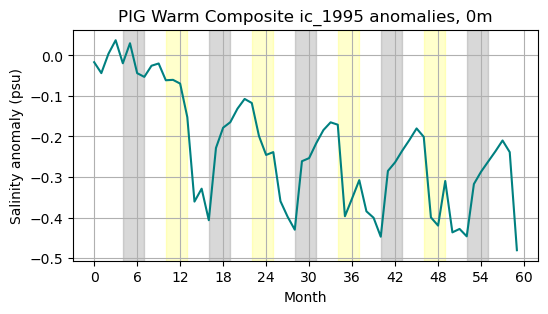

In [256]:
# Calc warm composite and cool composites plot salinity

exp_set ='ic_1995'
exp_set_runs = exp_set_dict_wind_order[exp_set] #order doesn't matter, it uses the runs as dict keys
warm_order_runs = exp_set_dict_warm_order[exp_set]
warm_runs = warm_order_runs[0:4]
cool_runs = warm_order_runs[4:8]
print('warm runs',warm_runs)
print('cool runs',cool_runs)

warm_comp_sal = np.mean(np.array([sal_dict[run] for run in warm_runs]),axis=0)
cool_comp_sal = np.mean(np.array([sal_dict[run] for run in cool_runs]),axis=0)
ens_mean_sal = np.mean(np.array([sal_dict[run] for run in exp_set_runs]),axis=0)
print('sal done')

#PLOT salinity anomalies -----------------------
fig,ax0 = plt.subplots(1,1,figsize=(6,3))

ax0.set_title(sal_loc+' Warm Composite '+exp_set+' anomalies, '+str(sal_depth)+'m')
ax0.set_xlabel('Month')
ax0.set_xticks(np.arange(0,72,6))
ax0.set_ylabel('Salinity anomaly (psu)')
ax0.grid()

# Add shaded vertical boxes to highlight winter
season_start_idx = 4  #0 is feb, so DJF (summer) = 10,11,0; MAM (fall) = 1,2,3; JJA (winter) = 4,5,6; SON (spr) = 7,8,9
for start in range(season_start_idx, 60, 12):
    end = start + 3
    if end <= 60:
        ax0.axvspan(start, start+3, color='gray', alpha=0.3)


# shade summer
season_start_idx = 10 
for start in range(season_start_idx, 60, 12):
    end = start + 3
    if end <= 60:
        ax0.axvspan(start, start+3, color='yellow', alpha=0.2)
        
warm_comp_sal_anom = warm_comp_sal - ens_mean_sal
ax0.plot(warm_comp_sal_anom,label=sal_loc+' salinity anomaly',color='teal')

yr1_em_sal = np.mean(ens_mean_sal[0:12])
print('year 1 EM salinity: {:.2f}'.format(yr1_em_sal))
for i in range(5):
    yr_i_sal_anom = np.mean(warm_comp_sal_anom[i*12:i*12+12])
    print('Year '+str(i+1)+' annual mean salinity: {:.2f}'.format(yr_i_sal_anom)\
         +', a {:.2f}% change from EM yr 1'.format((yr_i_sal_anom/yr1_em_sal)*100))



In [291]:
# Calc salinity in a diff location at a given depth

sal2_loc = 'PIG'
# sal_loc = 'inner_shelf_corner'
sal2_depth = -100 #0 PIG and inner_Shelf_corner and -100 inner_shelf_corner are saved 
sal2_dict = {}
for run in all_runs_wind_order:
    print(run)
    try:
        sal_run = np.load('Saved Arrays/sal_tseries/'+str(sal2_depth)+'m_'+run+'_'+sal2_loc+'.npy')
        print('precalculated sals found for', run)
    except:
        sal_run = calc_salinity(run, sal2_loc, sal2_depth)
        fname = 'Saved Arrays/sal_tseries/'+str(sal2_depth)+'m_'+run+'_'+sal2_loc+'.npy'
        np.save(fname, sal_run)
        print('Saved array as', fname)
    
    sal2_dict[run] = sal_run

run_forc_erai_2015_rep_ic_1995
precalculated sals found for run_forc_erai_2015_rep_ic_1995
run_forc_erai_1991_rep_ic_1995
precalculated sals found for run_forc_erai_1991_rep_ic_1995
run_forc_erai_1982_rep_ic_1995
precalculated sals found for run_forc_erai_1982_rep_ic_1995
run_forc_erai_1994_rep_ic_1995
precalculated sals found for run_forc_erai_1994_rep_ic_1995
run_forc_erai_1992_rep_ic_1995
precalculated sals found for run_forc_erai_1992_rep_ic_1995
run_forc_erai_1984_rep_ic_1995
precalculated sals found for run_forc_erai_1984_rep_ic_1995
run_forc_erai_2009_rep_ic_1995
precalculated sals found for run_forc_erai_2009_rep_ic_1995
run_forc_erai_2003_rep_ic_1995
precalculated sals found for run_forc_erai_2003_rep_ic_1995
run_forc_erai_1989_rep_ic_1995
precalculated sals found for run_forc_erai_1989_rep_ic_1995
run_forc_erai_2011_rep_ic_1995
precalculated sals found for run_forc_erai_2011_rep_ic_1995
run_forc_erai_2015_rep_ic_2001
precalculated sals found for run_forc_erai_2015_rep_ic_2001

warm runs ['run_forc_erai_1982_rep_ic_1995', 'run_forc_erai_1984_rep_ic_1995', 'run_forc_erai_1989_rep_ic_1995', 'run_forc_erai_1992_rep_ic_1995']
cool runs ['run_forc_erai_1994_rep_ic_1995', 'run_forc_erai_2003_rep_ic_1995', 'run_forc_erai_2009_rep_ic_1995', 'run_forc_erai_1991_rep_ic_1995']
sal done
PIG -100 m depth
year 1 EM salinity: 34.15
Year 1 annual mean salinity: -0.01, a -0.04% change from EM yr 1
Year 2 annual mean salinity: -0.05, a -0.16% change from EM yr 1
Year 3 annual mean salinity: -0.10, a -0.28% change from EM yr 1
Year 4 annual mean salinity: -0.13, a -0.38% change from EM yr 1
Year 5 annual mean salinity: -0.15, a -0.44% change from EM yr 1


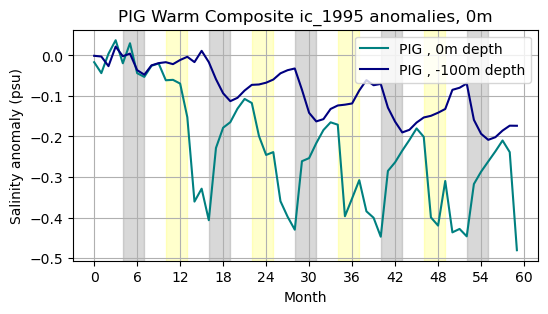

In [292]:
# Calc warm composite and cool composites plot salinity

exp_set ='ic_1995'
exp_set_runs = exp_set_dict_wind_order[exp_set] #order doesn't matter, it uses the runs as dict keys
warm_order_runs = exp_set_dict_warm_order[exp_set]
warm_runs = warm_order_runs[0:4]
cool_runs = warm_order_runs[4:8]
print('warm runs',warm_runs)
print('cool runs',cool_runs)

warm_comp_sal2 = np.mean(np.array([sal2_dict[run] for run in warm_runs]),axis=0)
cool_comp_sal2 = np.mean(np.array([sal2_dict[run] for run in cool_runs]),axis=0)
ens_mean_sal2 = np.mean(np.array([sal2_dict[run] for run in exp_set_runs]),axis=0)
print('sal done')

#PLOT salinity anomalies -----------------------
fig,ax0 = plt.subplots(1,1,figsize=(6,3))

ax0.set_title(sal_loc+' Warm Composite '+exp_set+' anomalies, '+str(sal_depth)+'m')
ax0.set_xlabel('Month')
ax0.set_xticks(np.arange(0,72,6))
ax0.set_ylabel('Salinity anomaly (psu)')
ax0.grid()

# Add shaded vertical boxes to highlight winter
season_start_idx = 4  #0 is feb, so DJF (summer) = 10,11,0; MAM (fall) = 1,2,3; JJA (winter) = 4,5,6; SON (spr) = 7,8,9
for start in range(season_start_idx, 60, 12):
    end = start + 3
    if end <= 60:
        ax0.axvspan(start, start+3, color='gray', alpha=0.3)


# shade summer
season_start_idx = 10 
for start in range(season_start_idx, 60, 12):
    end = start + 3
    if end <= 60:
        ax0.axvspan(start, start+3, color='yellow', alpha=0.2)
        
warm_comp_sal_anom = warm_comp_sal - ens_mean_sal
ax0.plot(warm_comp_sal_anom,label=sal_loc+' , '+str(sal_depth)+'m depth',color='teal')
warm_comp_sal_anom2 = warm_comp_sal2 - ens_mean_sal2
ax0.plot(warm_comp_sal_anom2,label=sal2_loc+' , '+str(sal2_depth)+'m depth',color='navy')
ax0.legend()

yr1_em_sal = np.mean(ens_mean_sal2[0:12])
print(sal2_loc, sal2_depth, 'm depth')
print('year 1 EM salinity: {:.2f}'.format(yr1_em_sal))
for i in range(5):
    yr_i_sal_anom = np.mean(warm_comp_sal_anom2[i*12:i*12+12])
    print('Year '+str(i+1)+' annual mean salinity: {:.2f}'.format(yr_i_sal_anom)\
         +', a {:.2f}% change from EM yr 1'.format((yr_i_sal_anom/yr1_em_sal)*100))



Ens mean sal yr 1: 34.152893
run_forc_erai_1982_rep_ic_1995
Year 2 mean and change: -0.05407683 -0.15833748038858175
year 5 anom and change: -0.20636272 -0.6042320281267166
run_forc_erai_1984_rep_ic_1995
Year 2 mean and change: -0.07419745 -0.21725085098296404
year 5 anom and change: -0.21277301 -0.6230014376342297
run_forc_erai_1989_rep_ic_1995
Year 2 mean and change: -0.08473269 -0.24809814058244228
year 5 anom and change: -0.16019408 -0.4690498113632202
run_forc_erai_1992_rep_ic_1995
Year 2 mean and change: 0.00097020465 0.002840768502210267
year 5 anom and change: -0.021325747 -0.062441988848149776
run_forc_erai_1994_rep_ic_1995
Year 2 mean and change: 0.07715639 0.22591464221477509
year 5 anom and change: 0.104478836 0.3059150418266654
run_forc_erai_2003_rep_ic_1995
Year 2 mean and change: 0.02813848 0.08238973678089678
year 5 anom and change: 0.099782944 0.29216541443020105
run_forc_erai_2009_rep_ic_1995
Year 2 mean and change: 0.03473218 0.10169616434723139
year 5 anom and chang

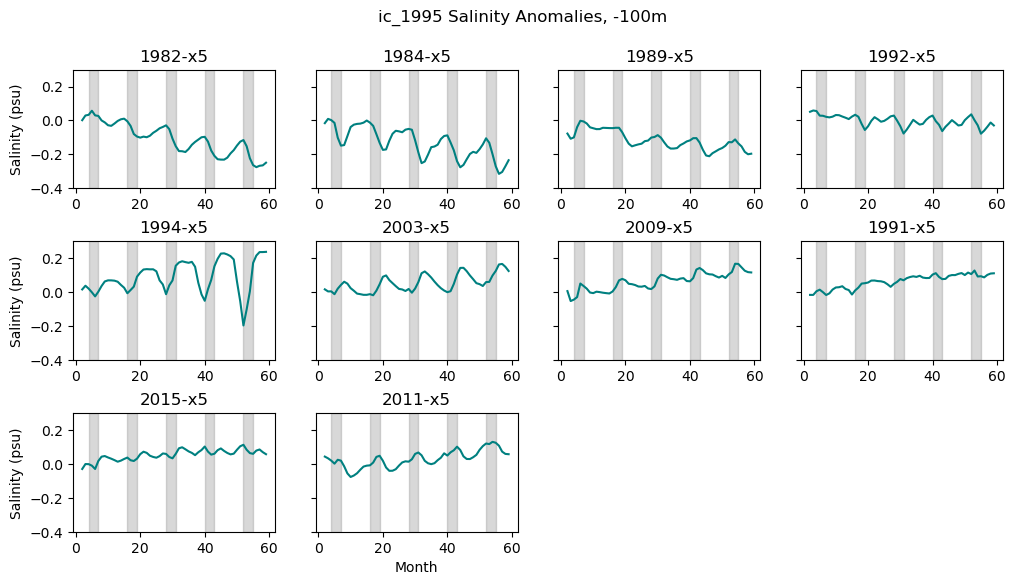

In [322]:
##### plot individual run salinity

# sal_plot_dict = sal_dict
# ens_mean_plot_sal = ens_mean_sal
# sal_plot_depth = sal_depth

sal_plot_dict = sal2_dict
ens_mean_plot_sal = ens_mean_sal2
sal_plot_depth = sal2_depth

window = 3
exp_set = 'ic_1995'

em_sal_yr_1 = np.mean(ens_mean_plot_sal[0:12])
print('Ens mean sal yr 1:',em_sal_yr_1)
runs = exp_set_dict_warm_order[exp_set]
fig, axes = plt.subplots(3,4,figsize=(12,6))
axes = axes.flatten()
for i in range(10): 
    
    ax = axes[i]
    run = runs[i]
    run_sal_anom = sal_plot_dict[run]-ens_mean_plot_sal
    ax.plot(pd.Series(run_sal_anom).rolling(window=window).mean(),color='teal')
    print(run)
    # display annual mean values in years 2 and 5
    print('Year 2 mean and change:',np.mean(run_sal_anom[12:24]), (np.mean(run_sal_anom[12:24])/em_sal_yr_1)*100)
    print('year 5 anom and change:',np.mean(run_sal_anom[48:60]),(np.mean(run_sal_anom[48:60])/em_sal_yr_1)*100)
    ax.set_title(run.split('run_forc_erai_')[1][0:4]+'-x5')
    if sal_plot_depth == 0:
        ax.set_ylim([-1.4,1.4])
    elif sal_plot_depth == -100:
        ax.set_ylim([-0.4,0.3])
    if i%4 != 0:
        ax.set_yticklabels([])
    else:
        ax.set_ylabel('Salinity (psu)')

    season_start_idx = 4  #0 is feb, so DJF (summer) = 10,11,0; MAM (fall) = 1,2,3; JJA (winter) = 4,5,6; SON (spr) = 7,8,9
    for start in range(season_start_idx, 60, 12):
        end = start + 3
        if end <= 60:
            ax.axvspan(start, start+3, color='gray', alpha=0.3)
    

ax.set_xlabel('Month')

plt.subplots_adjust(hspace=0.45,top=0.88)
plt.suptitle(exp_set+ ' Salinity Anomalies, '+str(sal_plot_depth)+'m')

# Remove the last two empty subplots
for ax in axes[-2:]:
    fig.delaxes(ax)


In [72]:
# Calc SI area in specified region

def calc_SIarea(run, region):
    exp_sia_full = flo.load_experiment_ds(run, 'all', 'state_2d_set2').SIarea
    exp_sia_full = exp_sia_full.isel(time=slice(0, 60))
    try:
        lati1, lati2, loni1, loni2 = fda.trough_idx_dict[region]
        exp_sia_reg = exp_sia_full.isel(lat=slice(lati1, lati2), lon=slice(loni1, loni2))
    except:
        lat1, lat2, lon1, lon2 = fda.analysis_region_dict[region]
        exp_sia_reg = exp_sia_full.sel(lat=slice(lat1, lat2), lon=slice(lon1, lon2)) 
                               
    exp_sia = exp_sia_reg.mean(dim='lat')
    exp_sia = exp_sia.mean(dim='lon')

    return exp_sia


# sia_loc = 'PIG'
sia_loc = 'inner_shelf_corner'
sia_dict = {}
for run in all_runs_wind_order:
    print(run)
    sia_run = calc_SIarea(run, sia_loc)
    sia_dict[run] = sia_run



run_forc_erai_2015_rep_ic_1995
run_forc_erai_1991_rep_ic_1995
run_forc_erai_1982_rep_ic_1995
run_forc_erai_1994_rep_ic_1995
run_forc_erai_1992_rep_ic_1995
run_forc_erai_1984_rep_ic_1995
run_forc_erai_2009_rep_ic_1995
run_forc_erai_2003_rep_ic_1995
run_forc_erai_1989_rep_ic_1995
run_forc_erai_2011_rep_ic_1995
run_forc_erai_2015_rep_ic_2001
run_forc_erai_1991_rep_ic_2001
run_forc_erai_1982_rep_ic_2001
run_forc_erai_1994_rep_ic_2001
run_forc_erai_1992_rep_ic_2001
run_forc_erai_1984_rep_ic_2001
run_forc_erai_2009_rep_ic_2001
run_forc_erai_2003_rep_ic_2001
run_forc_erai_1989_rep_ic_2001
run_forc_erai_2011_rep_ic_2001
run_forc_erai_2015_rep_ic_2008
run_forc_erai_1991_rep_ic_2008
run_forc_erai_1982_rep_ic_2008
run_forc_erai_1994_rep_ic_2008
run_forc_erai_1992_rep_ic_2008
run_forc_erai_1984_rep_ic_2008
run_forc_erai_2009_rep_ic_2008
run_forc_erai_2003_rep_ic_2008
run_forc_erai_1989_rep_ic_2008
run_forc_erai_2011_rep_ic_2008


In [73]:
# Calculate ocean surface FW flux timeseries near PIG (+ down, + increases salinity)
def calc_fw_flux(run, region):
    exp_fw_full = flo.load_experiment_ds(run, 'all', 'state_2d_set2').oceFWflx
    exp_fw_full = exp_fw_full.isel(time = slice(0,60))
    try:
        lati1, lati2, loni1, loni2 = fda.trough_idx_dict[region]
        exp_fw_reg = exp_fw_full.isel(lat=slice(lati1, lati2), lon=slice(loni1, loni2))
    except:
        lat1, lat2, lon1, lon2 = fda.analysis_region_dict[region]
        exp_fw_reg = exp_fw_full.sel(lat=slice(lat1, lat2), lon=slice(lon1, lon2))
    exp_fw = exp_fw_reg.mean(dim='lat')
    exp_fw = exp_fw.mean(dim='lon')

    return exp_fw


# fw_loc = 'PIG'
fw_loc = 'inner_shelf_corner'
fw_dict = {}
for run in all_runs_wind_order:
    print(run)
    fw_run = calc_fw_flux(run, fw_loc)
    fw_dict[run] = fw_run



run_forc_erai_2015_rep_ic_1995
run_forc_erai_1991_rep_ic_1995
run_forc_erai_1982_rep_ic_1995
run_forc_erai_1994_rep_ic_1995
run_forc_erai_1992_rep_ic_1995
run_forc_erai_1984_rep_ic_1995
run_forc_erai_2009_rep_ic_1995
run_forc_erai_2003_rep_ic_1995
run_forc_erai_1989_rep_ic_1995
run_forc_erai_2011_rep_ic_1995
run_forc_erai_2015_rep_ic_2001
run_forc_erai_1991_rep_ic_2001
run_forc_erai_1982_rep_ic_2001
run_forc_erai_1994_rep_ic_2001
run_forc_erai_1992_rep_ic_2001
run_forc_erai_1984_rep_ic_2001
run_forc_erai_2009_rep_ic_2001
run_forc_erai_2003_rep_ic_2001
run_forc_erai_1989_rep_ic_2001
run_forc_erai_2011_rep_ic_2001
run_forc_erai_2015_rep_ic_2008
run_forc_erai_1991_rep_ic_2008
run_forc_erai_1982_rep_ic_2008
run_forc_erai_1994_rep_ic_2008
run_forc_erai_1992_rep_ic_2008
run_forc_erai_1984_rep_ic_2008
run_forc_erai_2009_rep_ic_2008
run_forc_erai_2003_rep_ic_2008
run_forc_erai_1989_rep_ic_2008
run_forc_erai_2011_rep_ic_2008


In [4]:
# Calculate ice shelf ht flux timeseries under PIG 
# (ignores zeros, where ice shelf does not exist)
def calc_ice_ht_flux(run, region):
    lat1, lat2, lon1, lon2 = fda.analysis_region_dict[region]
    exp_ice_ht_full = flo.load_experiment_ds(run, 'all', 'iceshelf_state_set2').SHIhtFlx
    exp_ice_ht_reg = exp_ice_ht_full.sel(lat=slice(lat1, lat2), lon=slice(lon1, lon2))
    exp_ice_ht_reg = exp_ice_ht_reg.isel(time=slice(0, 60))
    # ignore zeros by replacing with nans, then calc nanmean
    exp_ice_ht_nan = exp_ice_ht_reg.where(exp_ice_ht_reg != 0)
    exp_ice_ht_mean = exp_ice_ht_nan.mean(dim='lat')
    exp_ice_ht_mean = exp_ice_ht_mean.mean(dim='lon')
    
    return exp_ice_ht_mean


# ice_ht_loc = 'PIG_shelf'
ice_ht_loc = 'inner_shelf_corner'
ice_ht_dict = {}
for run in all_runs_wind_order:
    print(run)
    ice_ht_run = calc_ice_ht_flux(run, ice_ht_loc)
    ice_ht_dict[run] = ice_ht_run



run_forc_erai_2015_rep_ic_1995
run_forc_erai_1991_rep_ic_1995
run_forc_erai_1982_rep_ic_1995
run_forc_erai_1994_rep_ic_1995
run_forc_erai_1992_rep_ic_1995
run_forc_erai_1984_rep_ic_1995
run_forc_erai_2009_rep_ic_1995
run_forc_erai_2003_rep_ic_1995
run_forc_erai_1989_rep_ic_1995
run_forc_erai_2011_rep_ic_1995
run_forc_erai_2015_rep_ic_2001
run_forc_erai_1991_rep_ic_2001
run_forc_erai_1982_rep_ic_2001
run_forc_erai_1994_rep_ic_2001
run_forc_erai_1992_rep_ic_2001
run_forc_erai_1984_rep_ic_2001
run_forc_erai_2009_rep_ic_2001
run_forc_erai_2003_rep_ic_2001
run_forc_erai_1989_rep_ic_2001
run_forc_erai_2011_rep_ic_2001
run_forc_erai_2015_rep_ic_2008
run_forc_erai_1991_rep_ic_2008
run_forc_erai_1982_rep_ic_2008
run_forc_erai_1994_rep_ic_2008
run_forc_erai_1992_rep_ic_2008
run_forc_erai_1984_rep_ic_2008
run_forc_erai_2009_rep_ic_2008
run_forc_erai_2003_rep_ic_2008
run_forc_erai_1989_rep_ic_2008
run_forc_erai_2011_rep_ic_2008


In [5]:
# Calculate ice shelf FW flux timeseries under PIG 

# (ignores zeros, where ice shelf does not exist)
# positive upward

def calc_ice_fw_flux(run, region):
    lat1, lat2, lon1, lon2 = fda.analysis_region_dict[region]
    exp_ice_fw_full = flo.load_experiment_ds(run, 'all', 'iceshelf_state_set2').SHIfwFlx
    exp_ice_fw_reg = exp_ice_fw_full.sel(lat=slice(lat1, lat2), lon=slice(lon1, lon2))
    exp_ice_fw_reg = exp_ice_fw_reg.isel(time=slice(0, 60))
    # ignore zeros by replacing with nans, then calc nanmean
    exp_ice_fw_nan = exp_ice_fw_reg.where(exp_ice_fw_reg != 0)
    exp_ice_fw_mean = exp_ice_fw_nan.mean(dim='lat')
    exp_ice_fw_mean = exp_ice_fw_mean.mean(dim='lon')
    
    return exp_ice_fw_mean


# ice_fw_loc = 'PIG_shelf'
ice_fw_loc = 'inner_shelf_corner'
ice_fw_dict = {}
for run in all_runs_wind_order:
    print(run)
    ice_fw_run = calc_ice_fw_flux(run, ice_fw_loc)
    ice_fw_dict[run] = ice_fw_run


run_forc_erai_2015_rep_ic_1995
run_forc_erai_1991_rep_ic_1995
run_forc_erai_1982_rep_ic_1995
run_forc_erai_1994_rep_ic_1995
run_forc_erai_1992_rep_ic_1995
run_forc_erai_1984_rep_ic_1995
run_forc_erai_2009_rep_ic_1995
run_forc_erai_2003_rep_ic_1995
run_forc_erai_1989_rep_ic_1995
run_forc_erai_2011_rep_ic_1995
run_forc_erai_2015_rep_ic_2001
run_forc_erai_1991_rep_ic_2001
run_forc_erai_1982_rep_ic_2001
run_forc_erai_1994_rep_ic_2001
run_forc_erai_1992_rep_ic_2001
run_forc_erai_1984_rep_ic_2001
run_forc_erai_2009_rep_ic_2001
run_forc_erai_2003_rep_ic_2001
run_forc_erai_1989_rep_ic_2001
run_forc_erai_2011_rep_ic_2001
run_forc_erai_2015_rep_ic_2008
run_forc_erai_1991_rep_ic_2008
run_forc_erai_1982_rep_ic_2008
run_forc_erai_1994_rep_ic_2008
run_forc_erai_1992_rep_ic_2008
run_forc_erai_1984_rep_ic_2008
run_forc_erai_2009_rep_ic_2008
run_forc_erai_2003_rep_ic_2008
run_forc_erai_1989_rep_ic_2008
run_forc_erai_2011_rep_ic_2008


In [12]:
# Check oceFWflw from SI diagnostics file
#SIatmFW: Net freshwater flux from atmosphere & land (+=down)
# Calculate ocean surface FW flux timeseries near PIG (+ down, + increases salinity)

def calc_fw_flux_v2(run, region):
    exp_fw_full = flo.load_experiment_ds(run, 'all', 'budg2d_zflux_set2').oceFWflx
    exp_fw_full = exp_fw_full.isel(time = slice(0,60))
    try:
        lati1, lati2, loni1, loni2 = fda.trough_idx_dict[region]
        exp_fw_reg = exp_fw_full.isel(lat=slice(lati1, lati2), lon=slice(loni1, loni2))
    except:
        lat1, lat2, lon1, lon2 = fda.analysis_region_dict[region]
        exp_fw_reg = exp_fw_full.sel(lat=slice(lat1, lat2), lon=slice(lon1, lon2))
    exp_fw = exp_fw_reg.mean(dim='lat')
    exp_fw = exp_fw.mean(dim='lon')

    return exp_fw


# fw_loc = 'PIG'
fw2_loc = 'inner_shelf_corner'
fw2_dict = {}
for run in all_runs_wind_order:
    print(run)
    fw_run = calc_fw_flux(run, fw_loc)
    fw2_dict[run] = fw_run


run_forc_erai_2015_rep_ic_1995
run_forc_erai_1991_rep_ic_1995
run_forc_erai_1982_rep_ic_1995
run_forc_erai_1994_rep_ic_1995
run_forc_erai_1992_rep_ic_1995
run_forc_erai_1984_rep_ic_1995
run_forc_erai_2009_rep_ic_1995
run_forc_erai_2003_rep_ic_1995
run_forc_erai_1989_rep_ic_1995
run_forc_erai_2011_rep_ic_1995
run_forc_erai_2015_rep_ic_2001
run_forc_erai_1991_rep_ic_2001
run_forc_erai_1982_rep_ic_2001
run_forc_erai_1994_rep_ic_2001
run_forc_erai_1992_rep_ic_2001
run_forc_erai_1984_rep_ic_2001
run_forc_erai_2009_rep_ic_2001
run_forc_erai_2003_rep_ic_2001
run_forc_erai_1989_rep_ic_2001
run_forc_erai_2011_rep_ic_2001
run_forc_erai_2015_rep_ic_2008
run_forc_erai_1991_rep_ic_2008
run_forc_erai_1982_rep_ic_2008
run_forc_erai_1994_rep_ic_2008
run_forc_erai_1992_rep_ic_2008
run_forc_erai_1984_rep_ic_2008
run_forc_erai_2009_rep_ic_2008
run_forc_erai_2003_rep_ic_2008
run_forc_erai_1989_rep_ic_2008
run_forc_erai_2011_rep_ic_2008


In [13]:
# Check FW flux from atmosphere and land (I think this excludes the ice shelf...?)

#SIatmFW: Net freshwater flux from atmosphere & land (+=down)

def calc_atm_fw_flux(run, region):
    exp_atm_fw_full = flo.load_experiment_ds(run, 'all', 'budg2d_zflux_set2').SIatmFW
    exp_atm_fw_full = exp_atm_fw_full.isel(time = slice(0,60))
    try:
        lati1, lati2, loni1, loni2 = fda.trough_idx_dict[region]
        exp_atm_fw_reg = exp_atm_fw_full.isel(lat=slice(lati1, lati2), lon=slice(loni1, loni2))
    except:
        lat1, lat2, lon1, lon2 = fda.analysis_region_dict[region]
        exp_atm_fw_reg = exp_atm_fw_full.sel(lat=slice(lat1, lat2), lon=slice(lon1, lon2))
    exp_atm_fw = exp_atm_fw_reg.mean(dim='lat')
    exp_atm_fw = exp_atm_fw.mean(dim='lon')

    return exp_atm_fw


# fw_loc = 'PIG'
atm_fw_loc = 'inner_shelf_corner'
atm_fw_dict = {}
for run in all_runs_wind_order:
    print(run)
    atm_fw_run = calc_atm_fw_flux(run, fw_loc)
    atm_fw_dict[run] = atm_fw_run


run_forc_erai_2015_rep_ic_1995
run_forc_erai_1991_rep_ic_1995
run_forc_erai_1982_rep_ic_1995
run_forc_erai_1994_rep_ic_1995
run_forc_erai_1992_rep_ic_1995
run_forc_erai_1984_rep_ic_1995
run_forc_erai_2009_rep_ic_1995
run_forc_erai_2003_rep_ic_1995
run_forc_erai_1989_rep_ic_1995
run_forc_erai_2011_rep_ic_1995
run_forc_erai_2015_rep_ic_2001
run_forc_erai_1991_rep_ic_2001
run_forc_erai_1982_rep_ic_2001
run_forc_erai_1994_rep_ic_2001
run_forc_erai_1992_rep_ic_2001
run_forc_erai_1984_rep_ic_2001
run_forc_erai_2009_rep_ic_2001
run_forc_erai_2003_rep_ic_2001
run_forc_erai_1989_rep_ic_2001
run_forc_erai_2011_rep_ic_2001
run_forc_erai_2015_rep_ic_2008
run_forc_erai_1991_rep_ic_2008
run_forc_erai_1982_rep_ic_2008
run_forc_erai_1994_rep_ic_2008
run_forc_erai_1992_rep_ic_2008
run_forc_erai_1984_rep_ic_2008
run_forc_erai_2009_rep_ic_2008
run_forc_erai_2003_rep_ic_2008
run_forc_erai_1989_rep_ic_2008
run_forc_erai_2011_rep_ic_2008


In [13]:
# Calculate P-E in specified region (in m/s)


def calc_p_minus_e(run, region):
    lat1, lat2, lon1, lon2 = fda.analysis_region_dict[region]
    
    exp_precip_full = flo.load_experiment_ds(run, 'all', 'EXF_forcing_set2').EXFpreci
    exp_precip_reg = exp_precip_full.sel(lat=slice(lat1, lat2), lon=slice(lon1, lon2))
    exp_precip_reg = exp_precip_reg.isel(time=slice(0, 60))
    exp_precip_mean = exp_precip_reg.mean(dim='lat')
    exp_precip_mean = exp_precip_mean.mean(dim='lon')

    exp_evap_full = flo.load_experiment_ds(run, 'all', 'EXF_forcing_set2').EXFevap
    exp_evap_reg = exp_evap_full.sel(lat=slice(lat1, lat2), lon=slice(lon1, lon2))
    exp_evap_reg = exp_evap_reg.isel(time=slice(0, 60))
    exp_evap_mean = exp_evap_reg.mean(dim='lat')
    exp_evap_mean = exp_evap_mean.mean(dim='lon')

    exp_p_minus_e_mean = exp_precip_mean - exp_evap_mean
    
    return exp_p_minus_e_mean

# ice_fw_loc = 'PIG_shelf'
p_minus_e_loc = 'inner_shelf_corner'
p_minus_e_dict = {}
for run in all_runs_wind_order:
    print(run)
    p_minus_e_run = calc_p_minus_e(run, p_minus_e_loc)
    p_minus_e_dict[run] = p_minus_e_run


run_forc_erai_2015_rep_ic_1995
run_forc_erai_1991_rep_ic_1995
run_forc_erai_1982_rep_ic_1995
run_forc_erai_1994_rep_ic_1995
run_forc_erai_1992_rep_ic_1995
run_forc_erai_1984_rep_ic_1995
run_forc_erai_2009_rep_ic_1995
run_forc_erai_2003_rep_ic_1995
run_forc_erai_1989_rep_ic_1995
run_forc_erai_2011_rep_ic_1995
run_forc_erai_2015_rep_ic_2001
run_forc_erai_1991_rep_ic_2001
run_forc_erai_1982_rep_ic_2001
run_forc_erai_1994_rep_ic_2001
run_forc_erai_1992_rep_ic_2001
run_forc_erai_1984_rep_ic_2001
run_forc_erai_2009_rep_ic_2001
run_forc_erai_2003_rep_ic_2001
run_forc_erai_1989_rep_ic_2001
run_forc_erai_2011_rep_ic_2001
run_forc_erai_2015_rep_ic_2008
run_forc_erai_1991_rep_ic_2008
run_forc_erai_1982_rep_ic_2008
run_forc_erai_1994_rep_ic_2008
run_forc_erai_1992_rep_ic_2008
run_forc_erai_1984_rep_ic_2008
run_forc_erai_2009_rep_ic_2008
run_forc_erai_2003_rep_ic_2008
run_forc_erai_1989_rep_ic_2008
run_forc_erai_2011_rep_ic_2008


In [7]:
# Calc warm composite and cool composites and filter out high freq (either sub-annual or sub-seasonal)

exp_set = 'ic_2001'
exp_set_runs = exp_set_dict_wind_order[exp_set] #order doesn't matter, it uses the runs as dict keys
warm_order_runs = exp_set_dict_warm_order[exp_set]
warm_runs = warm_order_runs[0:4]
cool_runs = warm_order_runs[4:8]
print('warm runs',warm_runs)
print('cool runs',cool_runs)

# warm_comp_tcd = np.mean(np.array([tcd_dict[run] for run in warm_runs]),axis=0) #shape 60
# cool_comp_tcd = np.mean(np.array([tcd_dict[run] for run in cool_runs]),axis=0)
# ens_mean_tcd = np.mean(np.array([tcd_dict[run] for run in exp_set_runs]),axis=0)
# print('tcd done')

# warm_comp_sia = np.mean(np.array([sia_dict[run] for run in warm_runs]),axis=0)
# cool_comp_sia = np.mean(np.array([sia_dict[run] for run in cool_runs]),axis=0)
# ens_mean_sia = np.mean(np.array([sia_dict[run] for run in exp_set_runs]),axis=0)

# warm_comp_fw = np.mean(np.array([fw_dict[run] for run in warm_runs]),axis=0)
# cool_comp_fw = np.mean(np.array([fw_dict[run] for run in cool_runs]),axis=0)
# ens_mean_fw = np.mean(np.array([fw_dict[run] for run in exp_set_runs]),axis=0)
# print('fw done')

warm_comp_ice_ht = np.mean(np.array([ice_ht_dict[run] for run in warm_runs]),axis=0)
cool_comp_ice_ht = np.mean(np.array([ice_ht_dict[run] for run in cool_runs]),axis=0)
ens_mean_ice_ht = np.mean(np.array([ice_ht_dict[run] for run in exp_set_runs]),axis=0)
print('ice ht done')

warm_comp_ice_fw = np.mean(np.array([ice_fw_dict[run] for run in warm_runs]),axis=0)
cool_comp_ice_fw = np.mean(np.array([ice_fw_dict[run] for run in cool_runs]),axis=0)
ens_mean_ice_fw = np.mean(np.array([ice_fw_dict[run] for run in exp_set_runs]),axis=0)


warm runs ['run_forc_erai_1982_rep_ic_2001', 'run_forc_erai_1984_rep_ic_2001', 'run_forc_erai_1989_rep_ic_2001', 'run_forc_erai_1992_rep_ic_2001']
cool runs ['run_forc_erai_1994_rep_ic_2001', 'run_forc_erai_2003_rep_ic_2001', 'run_forc_erai_2009_rep_ic_2001', 'run_forc_erai_1991_rep_ic_2001']
ice ht done


In [8]:
# show values for ice FWflux changes (kg/m^2/s, Ice shelf fresh water flux (positive upward))
yr1_em_ice_fw = np.mean(ens_mean_ice_fw[0:12])
print(ice_fw_loc)
print('year 1 ice FW: {:.8f}'.format(yr1_em_ice_fw))
warm_comp_ice_fw_anom = warm_comp_ice_fw - ens_mean_ice_fw
for i in range(5):
    yr_i_ice_fw_anom = np.mean(warm_comp_ice_fw_anom[i*12:i*12+12])
    print('Year '+str(i+1)+' annual mean ice FW flux anom: {:.8f}'.format(yr_i_ice_fw_anom)\
         +', a {:.2f}% change from EM yr 1'.format((yr_i_ice_fw_anom/yr1_em_ice_fw)*100))



# show values for ice heat flux changes (W/m^2, Ice shelf heat flux  (positive upward))
yr1_em_ice_ht = np.mean(ens_mean_ice_ht[0:12])
print(ice_ht_loc)
print('year 1 Ice heat flux: {:.4f}'.format(yr1_em_ice_ht))
warm_comp_ice_ht_anom = warm_comp_ice_ht - ens_mean_ice_ht
for i in range(5):
    yr_i_ice_ht_anom = np.mean(warm_comp_ice_ht_anom[i*12:i*12+12])
    print('Year '+str(i+1)+' annual mean ice heat flux anom: {:.2f}'.format(yr_i_ice_ht_anom)\
         +', a {:.2f}% change from EM yr 1'.format((yr_i_ice_ht_anom/yr1_em_ice_ht)*100))



inner_shelf_corner
year 1 ice FW: -0.00038709
Year 1 annual mean ice FWflux anom: -0.00000756, a 1.95% change from EM yr 1
Year 2 annual mean ice FWflux anom: -0.00004617, a 11.93% change from EM yr 1
Year 3 annual mean ice FWflux anom: -0.00010237, a 26.45% change from EM yr 1
Year 4 annual mean ice FWflux anom: -0.00013680, a 35.34% change from EM yr 1
Year 5 annual mean ice FWflux anom: -0.00016621, a 42.94% change from EM yr 1
inner_shelf_corner
year 1 Ice heat flux: 130.8764
Year 1 annual mean ice heat flux anom: 2.56, a 1.96% change from EM yr 1
Year 2 annual mean ice heat flux anom: 15.66, a 11.97% change from EM yr 1
Year 3 annual mean ice heat flux anom: 34.73, a 26.53% change from EM yr 1
Year 4 annual mean ice heat flux anom: 46.38, a 35.44% change from EM yr 1
Year 5 annual mean ice heat flux anom: 56.35, a 43.06% change from EM yr 1


sea ice loc: inner_shelf_corner
sal loc: PIG
temp loc: inner_shelf_corner


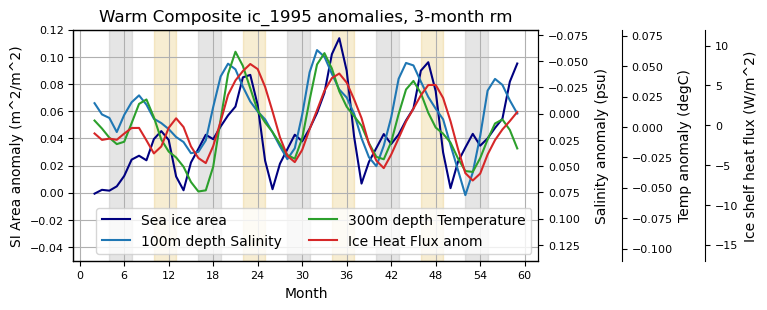

In [349]:
#PLOT sea ice and salinity anomalies, detrending to match peaks -----------------------
from scipy.signal import detrend

fig,ax0 = plt.subplots(1,1,figsize=(6,3))
window = 3

# Plot SI area on left y axis
warm_comp_sia_anom = warm_comp_sia - ens_mean_sia
sia_tseries = pd.Series(warm_comp_sia_anom).rolling(window=window).mean()
ax0.plot(sia_tseries,label='Sea ice area',color='navy')

# Plot salinity anomalies
ax1 = ax0.twinx()
ax1.spines['right'].set_position(('outward', 0)) 
sal2_tseries = pd.Series(warm_comp_sal2 - ens_mean_sal2).rolling(window=window).mean()
sal2_plot_tseries = sal2_tseries
sal2_plot_tseries[window-1:] = detrend(sal2_tseries[window-1:])
ax1.plot(sal2_plot_tseries,label=str(sal2_depth)[1:]+'m depth Salinity',color='tab:blue')

# Plot temperature
ax2 = ax0.twinx()
ax2.spines['right'].set_position(('outward', 60)) 
temp_tseries = pd.Series(warm_comp_temp - ens_mean_temp).rolling(window=window).mean()
temp_plot_tseries = temp_tseries
temp_plot_tseries[window-1:] = detrend(temp_tseries[window-1:])
ax2.plot(temp_plot_tseries,label=str(temp_depth)[1:]+'m depth Temperature',color='tab:green')

ax3 = ax0.twinx()
ax3.spines['right'].set_position(('outward', 120)) 
ice_ht_tseries = pd.Series(warm_comp_ice_ht - ens_mean_ice_ht).rolling(window=window).mean()
ice_ht_plot_tseries = ice_ht_tseries
ice_ht_plot_tseries[window-1:] = detrend(ice_ht_tseries[window-1:])
ax3.plot(ice_ht_plot_tseries,label='Ice Heat Flux anom',color='tab:red')

axes = [ax0,ax1,ax2, ax3]

# Plot uc strength

if window == 6:
    uc_tseries = pd.Series(warm_comp_uc - ens_mean_uc).rolling(window=window).mean()
    uc_plot_tseries = uc_tseries
    uc_plot_tseries[window-1:] = detrend(uc_tseries[window-1:])
    ax4 = ax0.twinx()
    ax4.spines['right'].set_position(('outward', 150)) 
    ax4.plot(uc_plot_tseries,label='Undercurrent Strength',color='tab:orange')
    ax4.set_ylabel('Undercurrent strength anomaly (m/s)')
    axes.append(ax4)

# Add shaded vertical boxes to highlight seasons
# 0 is feb, so DJF (summer) = 10,11,0; MAM (fall) = 1,2,3; JJA (winter) = 4,5,6; SON (spr) = 7,8,9
# shade winter gray
season_start_idx = 4 
for start in range(season_start_idx, 60, 12):
    end = start + 3
    if end <= 60:
        ax0.axvspan(start, start+3, color='gray', alpha=0.2)
# shade summer yellow
season_start_idx = 10 
for start in range(season_start_idx, 60, 12):
    end = start + 3
    if end <= 60:
        ax0.axvspan(start, start+3, color='goldenrod', alpha=0.2)

# Add legend for all axes

for ax in axes:
    lines, labels = ax.get_legend_handles_labels()
    if ax == ax0:
        all_lines = lines
        all_labels = labels
    else:
        all_lines += lines
        all_labels += labels
    ax.tick_params(axis='both', which='major', labelsize=8)
ax0.legend(all_lines, all_labels, loc='lower right', ncol=2)#,bbox_to_anchor=[-0.1,-.2])

ax0.set_title('Warm Composite '+exp_set+' anomalies, '+str(window)+'-month rm')
ax0.set_xlabel('Month')
ax0.set_xticks(np.arange(0,66,6))


# ax0.set_ylim([-0.01,0.08])
if window == 6:
    ax1.set_ylim([-0.05,0.09]) #sal
    ax2.set_ylim([-0.08,0.05]) #temp
    ax3.set_ylim([-0.01,0.01]) #ice ht flx
    ax4.set_ylim([-0.008,0.004]) #uc
elif window == 3:
    ax0.set_ylim([-0.05,0.12])
    ax1.set_ylim([-0.08,0.14]) #sal
    ax2.set_ylim([-0.11,0.08]) #temp
    ax3.set_ylim([-17,12]) #ice ht flux
    # ax4.set_ylim([-0.016,0.015])
elif window == 1:
    ax0.set_ylim([-0.06,0.15])
    ax1.set_ylim([-0.08,0.12]) #sal
    ax2.set_ylim([-0.11,0.08]) #temp
    ax3.set_ylim([-14,10]) #ice ht flux


ax1.invert_yaxis() #invert sal so freshening matches peaks
ax0.grid()
ax0.set_ylabel('SI Area anomaly (m^2/m^2)')
ax1.set_ylabel('Salinity anomaly (psu)')
ax2.set_ylabel('Temp anomaly (degC)')
ax3.set_ylabel('Ice shelf heat flux (W/m^2)')


print('sea ice loc:',sia_loc)
print('sal loc:',sal2_loc)
print('temp loc:',temp_loc)



inner_shelf_corner
year 1 Sea ice area: 0.1637
Year 1 annual mean SIA anom: 0.02, a 11.73% change from EM yr 1
Year 2 annual mean SIA anom: 0.05, a 28.76% change from EM yr 1
Year 3 annual mean SIA anom: 0.05, a 33.27% change from EM yr 1
Year 4 annual mean SIA anom: 0.05, a 30.45% change from EM yr 1
Year 5 annual mean SIA anom: 0.05, a 28.97% change from EM yr 1
inner_shelf_corner
year 1 oce FW: -0.00002248
Year 1 annual mean oce FWflux anom: 0.00000561, a -24.95% change from EM yr 1
Year 2 annual mean oce FWflux anom: 0.00000231, a -10.28% change from EM yr 1
Year 3 annual mean oce FWflux anom: 0.00000421, a -18.71% change from EM yr 1
Year 4 annual mean oce FWflux anom: 0.00000269, a -11.97% change from EM yr 1
Year 5 annual mean oce FWflux anom: 0.00000470, a -20.91% change from EM yr 1
inner_shelf_corner
year 1 ice FW: -0.00043544
Year 1 annual mean ice FWflux anom: -0.00001186, a 2.72% change from EM yr 1
Year 2 annual mean ice FWflux anom: -0.00005474, a 12.57% change from EM y

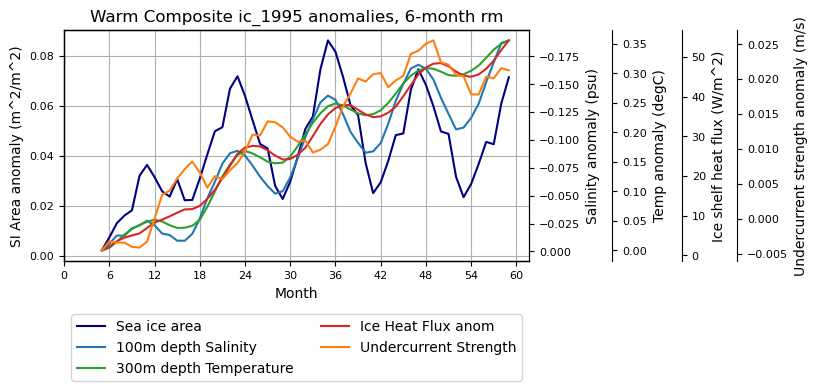

In [350]:
# plot sea ice, temp, heat flux, and undercurrent anomalies, showing trends

fig,ax0 = plt.subplots(1,1,figsize=(6,3))
window = 6

# Plot SI area on left y axis
warm_comp_sia_anom = warm_comp_sia - ens_mean_sia
sia_tseries = pd.Series(warm_comp_sia_anom).rolling(window=window).mean()
ax0.plot(sia_tseries,label='Sea ice area',color='navy')

# Plot salinity anomalies
ax1 = ax0.twinx()
ax1.spines['right'].set_position(('outward', 0)) 
sal2_tseries = pd.Series(warm_comp_sal2 - ens_mean_sal2).rolling(window=window).mean()
ax1.plot(sal2_tseries,label=str(sal2_depth)[1:]+'m depth Salinity',color='tab:blue')

# Plot temperature
ax2 = ax0.twinx()
ax2.spines['right'].set_position(('outward', 60)) 
temp_tseries = pd.Series(warm_comp_temp - ens_mean_temp).rolling(window=window).mean()
ax2.plot(temp_tseries,label=str(temp_depth)[1:]+'m depth Temperature',color='tab:green')

ax3 = ax0.twinx()
ax3.spines['right'].set_position(('outward', 110)) 
ice_ht_tseries = pd.Series(warm_comp_ice_ht - ens_mean_ice_ht).rolling(window=window).mean()
ax3.plot(ice_ht_tseries,label='Ice Heat Flux anom',color='tab:red')

axes = [ax0,ax1,ax2, ax3]

uc_tseries = pd.Series(warm_comp_uc - ens_mean_uc).rolling(window=window).mean()
ax4 = ax0.twinx()
ax4.spines['right'].set_position(('outward', 150)) 
ax4.plot(uc_tseries,label='Undercurrent Strength',color='tab:orange')
ax4.set_ylabel('Undercurrent strength anomaly (m/s)')
axes.append(ax4)



# Add legend for all axes

for ax in axes:
    lines, labels = ax.get_legend_handles_labels()
    if ax == ax0:
        all_lines = lines
        all_labels = labels
    else:
        all_lines += lines
        all_labels += labels
    ax.tick_params(axis='both', which='major', labelsize=8)
ax0.legend(all_lines, all_labels, loc='lower right', ncol=2,bbox_to_anchor=[1,-.55])

ax0.set_title('Warm Composite '+exp_set+' anomalies, '+str(window)+'-month rm')
ax0.set_xlabel('Month')
ax0.set_xticks(np.arange(0,66,6))


ax1.invert_yaxis() #invert sal so freshening matches peaks
ax0.grid()
ax0.set_ylabel('SI Area anomaly (m^2/m^2)')
ax1.set_ylabel('Salinity anomaly (psu)')
ax2.set_ylabel('Temp anomaly (degC)')
ax3.set_ylabel('Ice shelf heat flux (W/m^2)')

# show values for sea ice area changes
yr1_em_sia = np.mean(ens_mean_sia[0:12])
print(sia_loc)
print('year 1 Sea ice area: {:.4f}'.format(yr1_em_sia))
for i in range(5):
    yr_i_sia_anom = np.mean(warm_comp_sia_anom[i*12:i*12+12])
    print('Year '+str(i+1)+' annual mean SIA anom: {:.2f}'.format(yr_i_sia_anom)\
         +', a {:.2f}% change from EM yr 1'.format((yr_i_sia_anom/yr1_em_sia)*100))

# show values for oceFWflux changes
yr1_em_fw = np.mean(ens_mean_fw[0:12])
print(fw_loc)
print('year 1 oce FW: {:.8f}'.format(yr1_em_fw))
warm_comp_fw_anom = warm_comp_fw - ens_mean_fw
for i in range(5):
    yr_i_fw_anom = np.mean(warm_comp_fw_anom[i*12:i*12+12])
    print('Year '+str(i+1)+' annual mean oce FWflux anom: {:.8f}'.format(yr_i_fw_anom)\
         +', a {:.2f}% change from EM yr 1'.format((yr_i_fw_anom/yr1_em_fw)*100))

# show values for ice FWflux changes
yr1_em_ice_fw = np.mean(ens_mean_ice_fw[0:12])
print(ice_fw_loc)
print('year 1 ice FW: {:.8f}'.format(yr1_em_ice_fw))
warm_comp_ice_fw_anom = warm_comp_ice_fw - ens_mean_ice_fw
for i in range(5):
    yr_i_ice_fw_anom = np.mean(warm_comp_ice_fw_anom[i*12:i*12+12])
    print('Year '+str(i+1)+' annual mean ice FWflux anom: {:.8f}'.format(yr_i_ice_fw_anom)\
         +', a {:.2f}% change from EM yr 1'.format((yr_i_ice_fw_anom/yr1_em_ice_fw)*100))



# show values for ice heat flux changes
yr1_em_ice_ht = np.mean(ens_mean_ice_ht[0:12])
print(ice_ht_loc)
print('year 1 Ice heat flux: {:.4f}'.format(yr1_em_ice_ht))
warm_comp_ice_ht_anom = warm_comp_ice_ht - ens_mean_ice_ht
for i in range(5):
    yr_i_ice_ht_anom = np.mean(warm_comp_ice_ht_anom[i*12:i*12+12])
    print('Year '+str(i+1)+' annual mean ice heat flux anom: {:.2f}'.format(yr_i_ice_ht_anom)\
         +', a {:.2f}% change from EM yr 1'.format((yr_i_ice_ht_anom/yr1_em_ice_ht)*100))




In [ ]:
#PLOT warm composite undercurrent barotropic and baroclinic Anomalies -----------------------

fig,ax0 = plt.subplots(1,1,figsize=(6,3))

uc_anom = warm_comp_uc - ens_mean_uc
uc_barotropic = 

ax0.plot(uc_anom,label=uc_region+' UC strength anom',color='goldenrod')

ax0.legend(loc='upper left', ncol=2,bbox_to_anchor=[-0.1,-.2])
ax0.set_title('Warm Composite '+exp_set+' anomalies')
ax0.set_xlabel('Month')
ax0.set_xticks(np.arange(0,72,12))
ax0.set_ylabel('U velocity (m/s)')


FW contribution from ice shelf melt
year 1 : 0.27
year 2 : 1.06
year 3 : 0.97
year 4 : 0.97
year 5 : 0.95


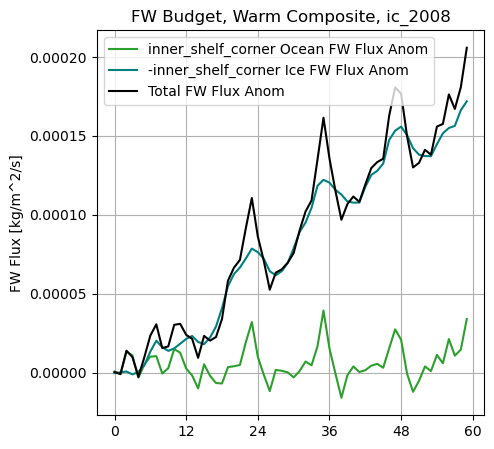

In [36]:
# Plot and calc warm comp freshwater budget using anomalies
fig, ax0 = plt.subplots(1,1,figsize=(5,5))
window = 1
warm_comp_fw_rm_anom = pd.Series(warm_comp_fw-ens_mean_fw).rolling(window=window).mean()
warm_comp_ice_fw_rm_anom = pd.Series(warm_comp_ice_fw-ens_mean_ice_fw).rolling(window=window).mean()
warm_comp_p_minus_e_anom = warm_comp_p_minus_e - ens_mean_p_minus_e
ax0.plot(warm_comp_fw_rm_anom,label=fw_loc+' Ocean FW Flux Anom',color='tab:green')
ax0.plot(-warm_comp_ice_fw_rm_anom,label='-'+ice_fw_loc+' Ice FW Flux Anom',color='teal')
fw_total_anom = warm_comp_fw_rm_anom - warm_comp_ice_fw_rm_anom
ax0.plot(fw_total_anom, label='Total FW Flux Anom',color='black')
plt.legend(ncol=1,loc='upper left')
plt.grid(True)
ax0.set_xticks(np.arange(0,72,12))
ax0.set_ylabel('FW Flux [kg/m^2/s]')
ax0.set_title('FW Budget, Warm Composite, '+exp_set)
# ax0.set_xlim([0,36])

ax1 = ax0.twinx()
ax1.plot(warm_comp_p_minus_e_anom,label='P-E Anom',color='teal')

# oceFW flux: net surface Fresh-Water flux into the ocean (+=down), >0 decreases salinity
# Ice FW flux: Ice shelf fresh water flux (positive upward), so i flipped the sign so positive downward to match oceFW flux.
i = 0
step = 12 #12 for annual, 6 for bi-annual
print('FW contribution from ice shelf melt')
while i < len(fw_total_anom):
    print('year',(i//step)+1, ': {:.2f}'.format(np.mean(-warm_comp_ice_fw_rm_anom[i:i+step] / fw_total_anom[i:i+step])))
    i += step

FW contribution from ice shelf melt
year 1 : 0.21
year 2 : 1.05
year 3 : 0.99
year 4 : 0.99
year 5 : 0.98


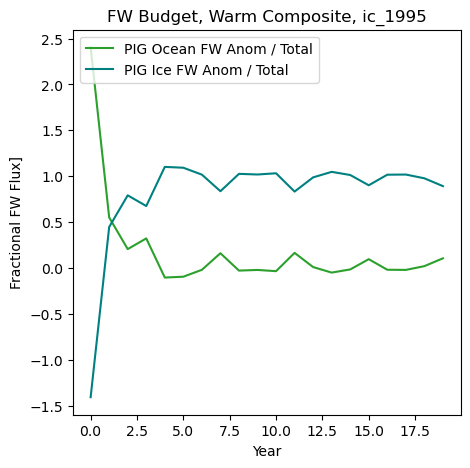

In [14]:
# Plot ratio of annual mean anomalies
fig, ax0 = plt.subplots(1,1,figsize=(5,5))
window = 1
warm_comp_fw_rm_anom = pd.Series(warm_comp_fw-ens_mean_fw).rolling(window=window).mean()
warm_comp_ice_fw_rm_anom = pd.Series(warm_comp_ice_fw-ens_mean_ice_fw).rolling(window=window).mean()
fw_total_anom = warm_comp_fw_rm_anom - warm_comp_ice_fw_rm_anom


# calculate annual means
n_months_avg = 3
n_chunks = 60 // n_months_avg
ann_mean_func = lambda lst: sum(lst) / len(lst)
warm_comp_fw_anom = warm_comp_fw - ens_mean_fw
warm_comp_ice_fw_anom = warm_comp_ice_fw - ens_mean_ice_fw
warm_comp_fw_ann = np.array(list(map(ann_mean_func, [warm_comp_fw_anom[i* n_months_avg : (i+1)* n_months_avg] for i in range(n_chunks)])))
warm_comp_ice_fw_ann = np.array(list(map(ann_mean_func, [-warm_comp_ice_fw_anom[i* n_months_avg : (i+1)* n_months_avg] for i in range(n_chunks)])))
total_fw_ann = warm_comp_fw_ann + warm_comp_ice_fw_ann
# ax0.plot(warm_comp_fw_ann,label='PIG Ocean FW Anom',color='tab:green')
# ax0.plot(warm_comp_ice_fw_ann,label='PIG Ice FW Anom',color='teal')
ax0.plot(warm_comp_fw_ann / total_fw_ann,label='PIG Ocean FW Anom / Total',color='tab:green')
ax0.plot(warm_comp_ice_fw_ann / total_fw_ann,label='PIG Ice FW Anom / Total',color='teal')


# ax0.plot(fw_total_anom, label='Total FW Flux Anom',color='black')
plt.legend(ncol=1,loc='upper left')
ax0.set_xlabel('Year')
ax0.set_ylabel('Fractional FW Flux]')
ax0.set_title('FW Budget, Warm Composite, '+exp_set)
# ax0.set_xlim([0,36])

# oceFW flux: net surface Fresh-Water flux into the ocean (+=down), >0 decreases salinity
# Ice FW flux: Ice shelf fresh water flux (positive upward), so i flipped the sign so positive downward to match oceFW flux.
i = 0
print('FW contribution from ice shelf melt')
while i < len(fw_total_anom):
    print('year',(i//12)+1, ': {:.2f}'.format(np.mean(-warm_comp_ice_fw_rm_anom[i:i+12] / fw_total_anom[i:i+12])))
    i += 12

FW contribution from ice shelf melt
year 1 : 0.44
year 2 : 0.58
year 3 : 1.09
year 4 : 1.05
year 5 : 1.00


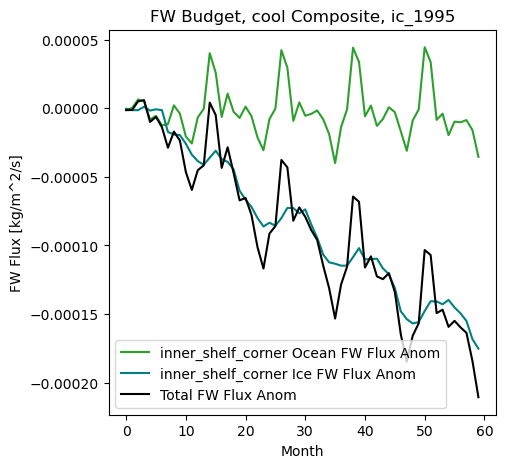

In [15]:
# Plot and calc cool comp freshwater budget using anomalies
fig, ax0 = plt.subplots(1,1,figsize=(5,5))
window = 1
cool_comp_fw_rm_anom = pd.Series(cool_comp_fw-ens_mean_fw).rolling(window=window).mean()
cool_comp_ice_fw_rm_anom = pd.Series(cool_comp_ice_fw-ens_mean_ice_fw).rolling(window=window).mean()
ax0.plot(cool_comp_fw_rm_anom,label=fw_loc+' Ocean FW Flux Anom',color='tab:green')
ax0.plot(-cool_comp_ice_fw_rm_anom,label=ice_fw_loc+' Ice FW Flux Anom',color='teal')
fw_total_anom = cool_comp_fw_rm_anom - cool_comp_ice_fw_rm_anom
ax0.plot(fw_total_anom, label='Total FW Flux Anom',color='black')
plt.legend(ncol=1,loc='lower left')
ax0.set_xlabel('Month')
ax0.set_ylabel('FW Flux [kg/m^2/s]')
ax0.set_title('FW Budget, cool Composite, '+exp_set)
# ax0.set_xlim([0,36])

# oceFW flux: net surface Fresh-Water flux into the ocean (+=down), >0 decreases salinity
# Ice FW flux: Ice shelf fresh water flux (positive upward), so i flipped the sign so positive downward to match oceFW flux.
i = 0
print('FW contribution from ice shelf melt')
while i < len(fw_total_anom):
    print('year',(i//12)+1, ': {:.2f}'.format(np.mean(-cool_comp_ice_fw_rm_anom[i:i+12] / fw_total_anom[i:i+12])))
    i += 12

Text(0, 0.5, 'inner_shelf_corner -500 temp (deg C)')

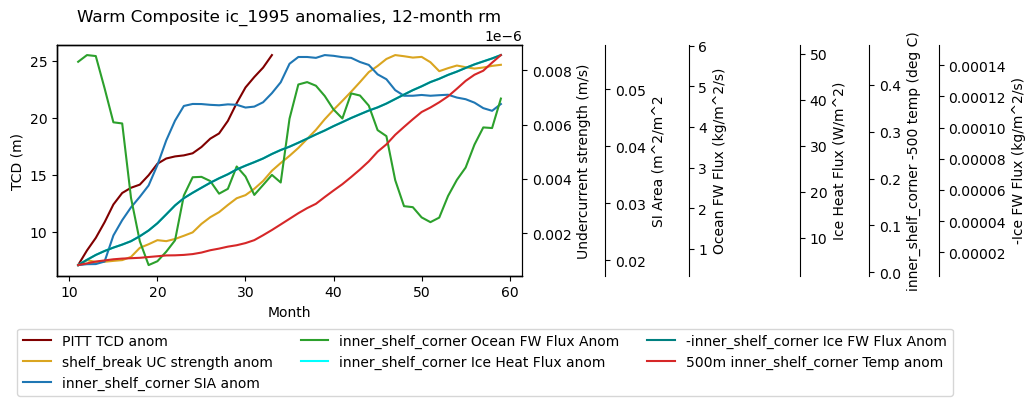

In [16]:
#PLOT all variable Anomalies -----------------------
fig,ax0 = plt.subplots(1,1,figsize=(6,3))
window = 12

ax0.plot(pd.Series(warm_comp_tcd - ens_mean_tcd).rolling(window=window).mean(),label=tcd_loc+' TCD anom', color='maroon')
ax1 = ax0.twinx()
ax1.plot(pd.Series(warm_comp_uc - ens_mean_uc).rolling(window=window).mean(),label=uc_region+' UC strength anom',color='goldenrod')
ax2 = ax0.twinx()
ax2.spines['right'].set_position(('outward', 60)) 
ax2.plot(pd.Series(warm_comp_sia - ens_mean_sia).rolling(window=window).mean(),label=sia_loc+' SIA anom',color='tab:blue')
ax3 = ax0.twinx()
ax3.spines['right'].set_position(('outward', 120)) 
ax3.plot(pd.Series(warm_comp_fw-ens_mean_fw).rolling(window=window).mean(),label=fw_loc+' Ocean FW Flux Anom',color='tab:green')
ax4 = ax0.twinx()
ax4.spines['right'].set_position(('outward', 200)) 
ax4.plot(pd.Series(warm_comp_ice_ht - ens_mean_ice_ht).rolling(window=window).mean(),label=ice_ht_loc+' Ice Heat Flux anom',color='cyan')
ax5 = ax0.twinx()
ax5.spines['right'].set_position(('outward', 300)) 
ax5.plot(-pd.Series(warm_comp_ice_fw - ens_mean_ice_fw).rolling(window=window).mean(),label='-'+ice_fw_loc+' Ice FW Flux Anom',color='teal')
ax6 = ax0.twinx()
ax6.spines['right'].set_position(('outward', 250)) 
ax6.plot(pd.Series(warm_comp_temp - ens_mean_temp).rolling(window=window).mean(),label=str(temp_depth)[1:]+'m '+temp_loc+' Temp anom',color='tab:red')

# Add legend for all axes
axes = [ax0,ax1,ax2,ax3,ax4,ax5,ax6]
for ax in axes:
    lines, labels = ax.get_legend_handles_labels()
    if ax == ax0:
        all_lines = lines
        all_labels = labels
    else:
        all_lines += lines
        all_labels += labels
ax0.legend(all_lines, all_labels, loc='upper left', ncol=3,bbox_to_anchor=[-0.1,-.2])

ax0.set_title('Warm Composite '+exp_set+' anomalies, '+str(window)+'-month rm')
ax0.set_xlabel('Month')
ax0.set_ylabel('TCD (m)')
ax1.set_ylabel('Undercurrent strength (m/s)')
ax2.set_ylabel('SI Area (m^2/m^2')
ax3.set_ylabel('Ocean FW Flux (kg/m^2/s)')
ax4.set_ylabel('Ice Heat Flux (W/m^2)') #Ice shelf heat flux  (positive upward)
ax5.set_ylabel('-Ice FW Flux (kg/m^2/s)') # Ice shelf fresh water flux (positive upward)
ax6.set_ylabel(temp_loc+ ' '+str(temp_depth)+' temp (deg C)') #Ice shelf heat flux  (positive upward)


Text(0, 0.5, 'inner_shelf_corner -500 temp (deg C)')

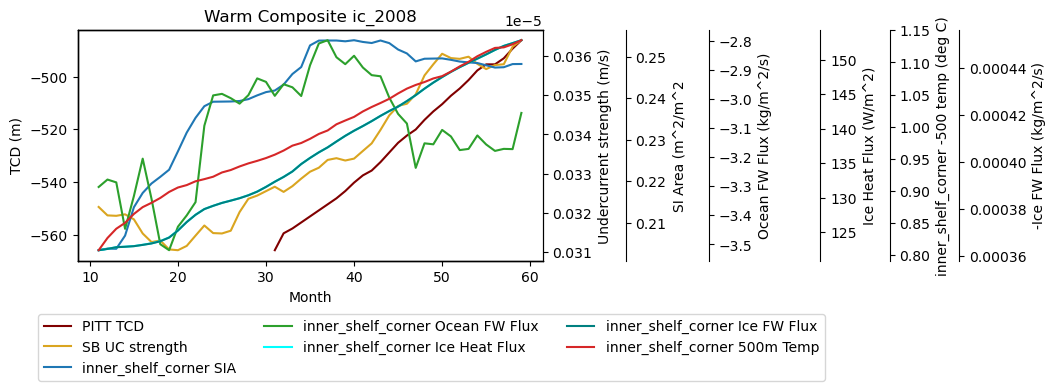

In [25]:
#PLOT all vars with actual values -----------------------
fig,ax0 = plt.subplots(1,1,figsize=(6,3))
window = 12

ax0.plot(pd.Series(warm_comp_tcd).rolling(window=window).mean(),label='PITT TCD', color='maroon')
ax1 = ax0.twinx()
ax1.plot(pd.Series(warm_comp_uc).rolling(window=window).mean(),label='SB UC strength',color='goldenrod')
ax2 = ax0.twinx()
ax2.spines['right'].set_position(('outward', 60)) 
ax2.plot(pd.Series(warm_comp_sia).rolling(window=window).mean(),label=sia_loc+' SIA',color='tab:blue')
ax3 = ax0.twinx()
ax3.spines['right'].set_position(('outward', 120)) 
ax3.plot(pd.Series(warm_comp_fw).rolling(window=window).mean(),label=fw_loc+' Ocean FW Flux',color='tab:green')
ax4 = ax0.twinx()
ax4.spines['right'].set_position(('outward', 200)) 
ax4.plot(pd.Series(warm_comp_ice_ht).rolling(window=window).mean(),label=ice_ht_loc+' Ice Heat Flux',color='cyan')
ax5 = ax0.twinx()
ax5.spines['right'].set_position(('outward', 300)) 
ax5.plot(-pd.Series(warm_comp_ice_fw).rolling(window=window).mean(),label=ice_fw_loc+' Ice FW Flux',color='teal')
ax6 = ax0.twinx()
ax6.spines['right'].set_position(('outward', 250)) 
ax6.plot(pd.Series(warm_comp_temp).rolling(window=window).mean(),label=temp_loc+' '+str(temp_depth)[1:]+'m Temp',color='tab:red')

# Add legend for all axes
axes = [ax0,ax1,ax2,ax3,ax4,ax5,ax6]
for ax in axes:
    lines, labels = ax.get_legend_handles_labels()
    if ax == ax0:
        all_lines = lines
        all_labels = labels
    else:
        all_lines += lines
        all_labels += labels
ax0.legend(all_lines, all_labels, loc='upper left', ncol=3,bbox_to_anchor=[-0.1,-.2])

ax0.set_title('Warm Composite '+exp_set)
ax0.set_xlabel('Month')
ax0.set_ylabel('TCD (m)')
ax1.set_ylabel('Undercurrent strength (m/s)')
ax2.set_ylabel('SI Area (m^2/m^2')
ax3.set_ylabel('Ocean FW Flux (kg/m^2/s)')
ax4.set_ylabel('Ice Heat Flux (W/m^2)') #Ice shelf heat flux  (positive upward)
ax5.set_ylabel('-Ice FW Flux (kg/m^2/s)') # Ice shelf fresh water flux (positive upward)
ax6.set_ylabel(temp_loc+ ' '+str(temp_depth)+' temp (deg C)') #Ice shelf heat flux  (positive upward)
